<a href="https://colab.research.google.com/github/Soob00/20251R0136COSE47101/blob/main/main/dataset2/notebooks/dataset2_SMI_SED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP1. 통계적 차이 검정**

# **STEP2~3. SMI/SED/진단 없음 트리기반 분석 및 SHAP**

## **모델 개선(최종)**

In [ ]:

# 데이터 다시 불러오기
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

In [ ]:
print(df.columns)


Index(['YEAR', 'AGE', 'EDUC', 'GENDER', 'SPHSERVICE', 'CMPSERVICE',
       'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH3', 'SAP', 'EMPLOY',
       'VETERAN', 'NUMMHS', 'TRAUSTREFLG', 'ALCSUBFLG', 'STATEFIP', 'CASEID',
       'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2',
       'ETHNIC_3', 'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
       'SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8',
       'SUB_9', 'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'MARSTAT_2',
       'MARSTAT_3', 'MARSTAT_4', 'SMISED_2', 'SMISED_3', 'DETNLF_2',
       'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable', 'LIVARAG_2',
       'LIVARAG_3', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4',
       'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9'],
      dtype='object')


In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# 1) 진단 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'OTHERDISFLG'
]


region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9', "AGE" #+age
]

df = df.drop(columns=diagnosis_vars+region_vars, errors='ignore')

# SMISED
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)

y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# 3) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4) 빠른 RandomOverSampler
print("Before OverSampling:", y_train.value_counts().to_dict())
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
print("After OverSampling:", pd.Series(y_train_res).value_counts().to_dict())

# 5) XGBoost 튜닝
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=2,
    min_child_weight=10,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)

model.fit(X_train_res, y_train_res)

# 6) Predict with threshold control
proba = model.predict_proba(X_test)

custom_pred = []
for p in proba:
    if p[1] > 0.859:   # SMI는 0.859 이상에서만 SMI
        custom_pred.append(1)
    elif p[2] > 0.467: # SED는 0.467 이상에서만 SED
        custom_pred.append(2)
    else:
        custom_pred.append(0)  # 나머지는 None


# 7) 결과 확인
acc = accuracy_score(y_test, custom_pred)
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, custom_pred))



Before OverSampling: {0: 670643, 2: 219519, 1: 28062}
After OverSampling: {0: 670643, 2: 670643, 1: 670643}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:37:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6709

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77    167661
           1       0.54      0.49      0.51      7016
           2       0.38      0.46      0.42     54880

    accuracy                           0.67    229557
   macro avg       0.57      0.57      0.57    229557
weighted avg       0.69      0.67      0.68    229557



In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# 예: SMI (1)에 대해
precision, recall, thresholds = precision_recall_curve(y_test == 1, proba[:, 1])

# F1이 최대인 Threshold 찾기
f1 = 2 * (precision * recall) / (precision + recall)
best_thresh = thresholds[np.argmax(f1)]

print(f"Best threshold for SMI: {best_thresh:.3f}")


Best threshold for SMI: 0.859


In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# SED (2)에 대해 Precision-Recall Curve 계산
precision2, recall2, thresholds2 = precision_recall_curve(y_test == 2, proba[:, 2])

# F1-score 최대인 지점 찾기
f1_2 = 2 * (precision2 * recall2) / (precision2 + recall2)
best_thresh2 = thresholds2[np.argmax(f1_2)]

print(f"Best threshold for SED: {best_thresh2:.3f}")


Best threshold for SED: 0.467


<class 'numpy.ndarray'>
300
(46, 3)
(300, 46)

클래스 0 (None)


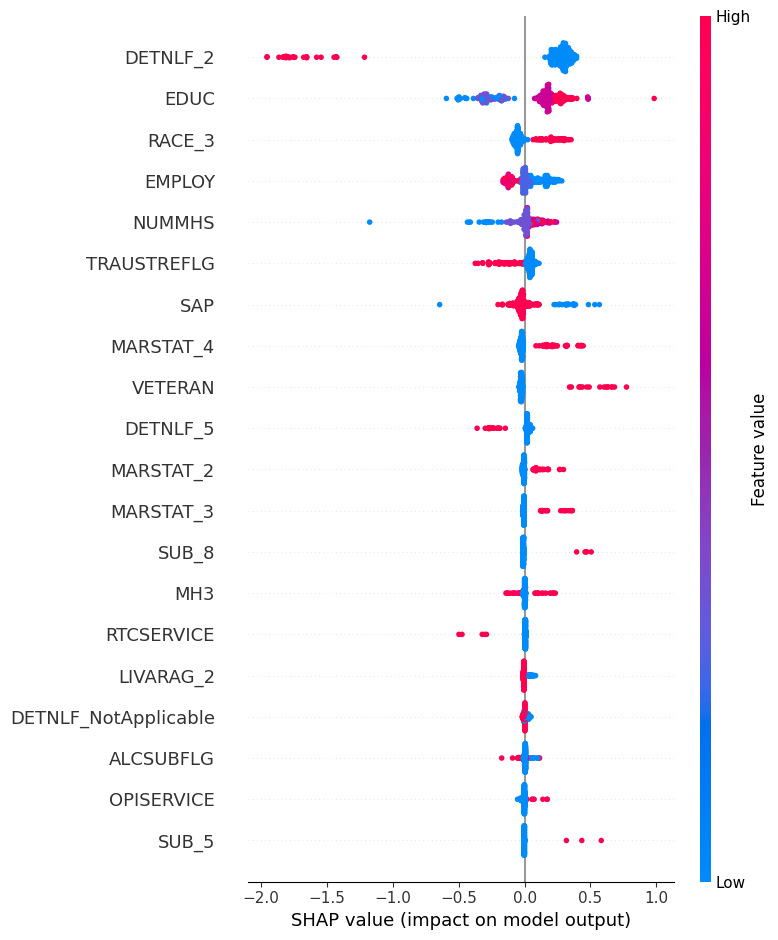


클래스 1 (SMI)


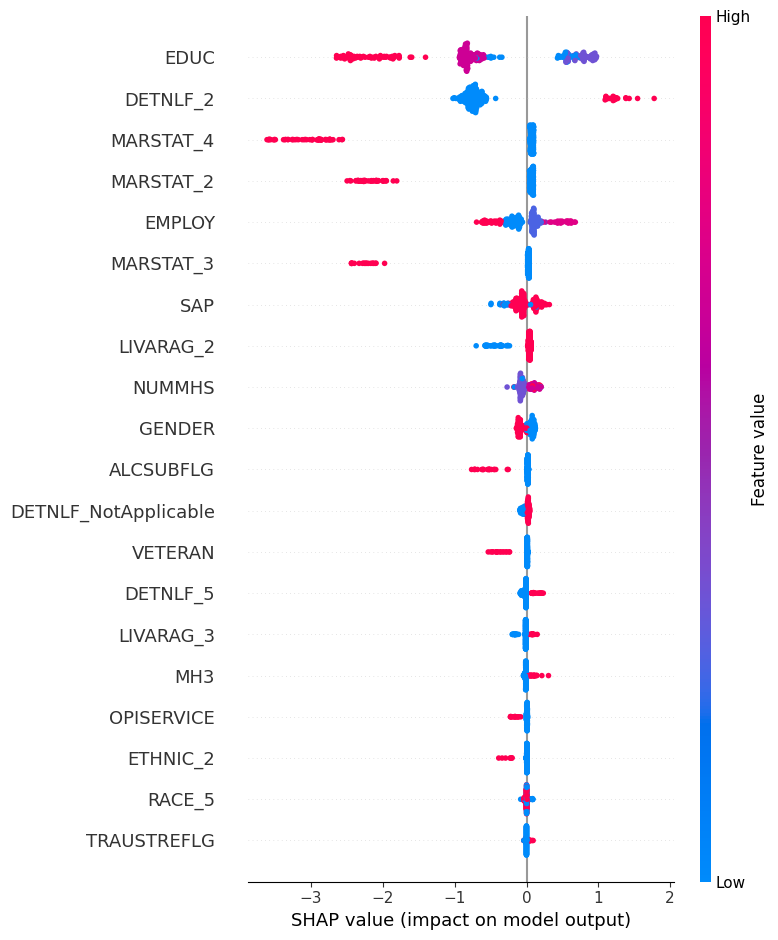


클래스 2 (SED)


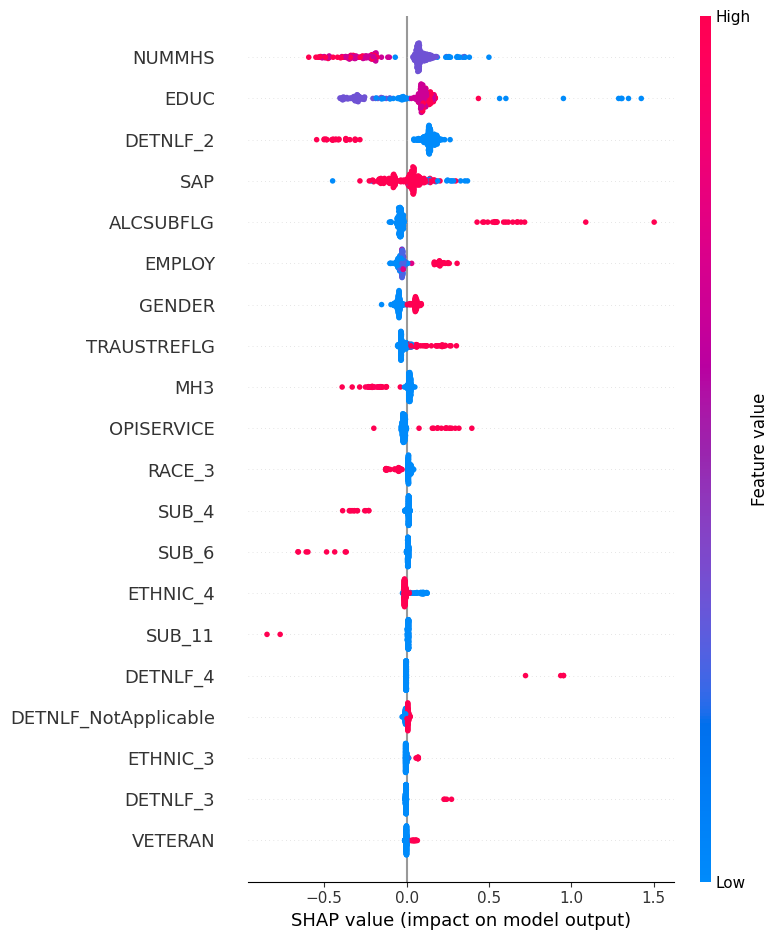

In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


DETNLF_2       0.402014
EDUC           0.235268
RACE_3         0.089392
EMPLOY         0.086655
NUMMHS         0.068078
TRAUSTREFLG    0.067771
SAP            0.063323
MARSTAT_4      0.058569
VETERAN        0.054189
DETNLF_5       0.043378
dtype: float32


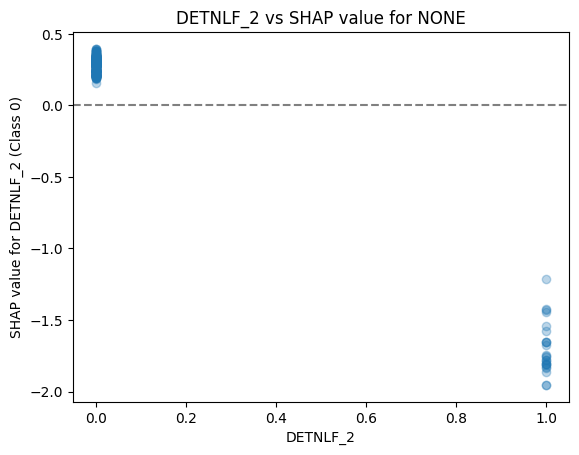

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 0)")
plt.title("DETNLF_2 vs SHAP value for NONE")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


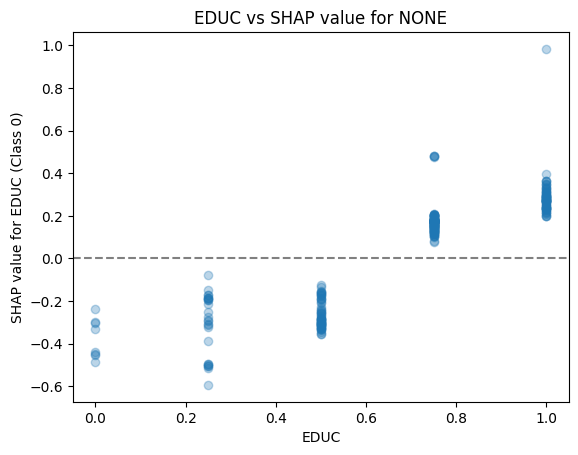

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDUC (Class 0)")
plt.title("EDUC vs SHAP value for NONE")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


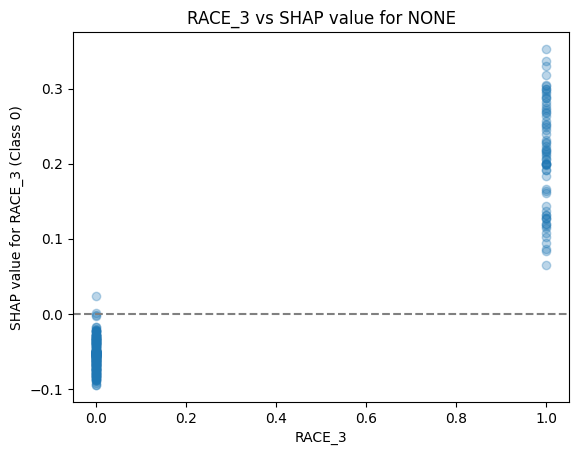

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["RACE_3"], shap_df["RACE_3"], alpha=0.3)
plt.xlabel("RACE_3")
plt.ylabel("SHAP value for RACE_3 (Class 0)")
plt.title("RACE_3 vs SHAP value for NONE")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


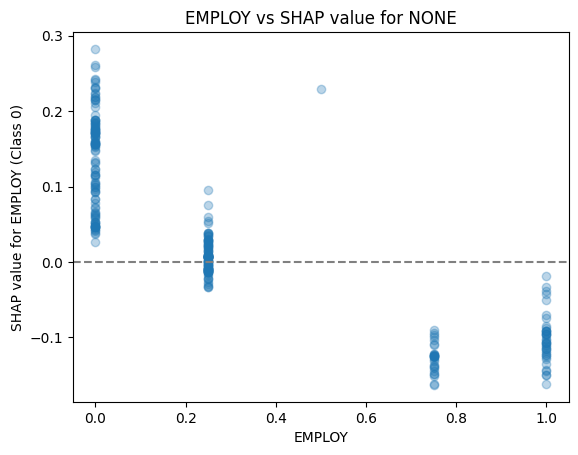

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 0)")
plt.title("EMPLOY vs SHAP value for NONE")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
# 클래스1 SMI SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


EDUC         1.104654
DETNLF_2     0.788674
MARSTAT_4    0.593325
MARSTAT_2    0.369365
EMPLOY       0.225057
MARSTAT_3    0.173602
SAP          0.123971
LIVARAG_2    0.099173
NUMMHS       0.081419
GENDER       0.075271
dtype: float32


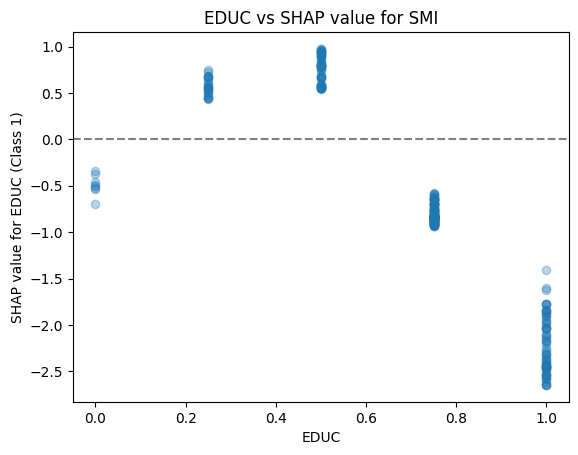

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDUC (Class 1)")
plt.title("EDUC vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


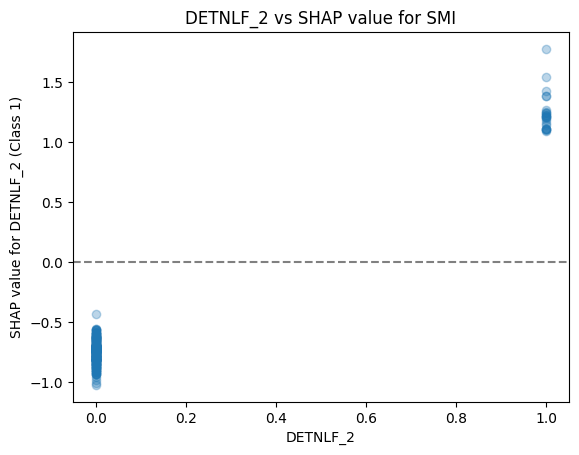

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


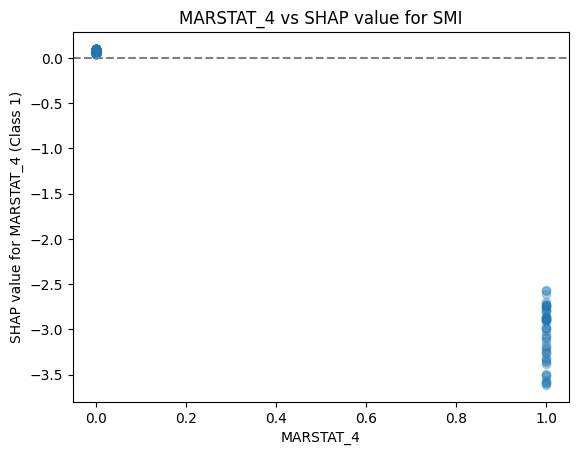

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["MARSTAT_4"], shap_df["MARSTAT_4"], alpha=0.3)
plt.xlabel("MARSTAT_4")
plt.ylabel("SHAP value for MARSTAT_4 (Class 1)")
plt.title("MARSTAT_4 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


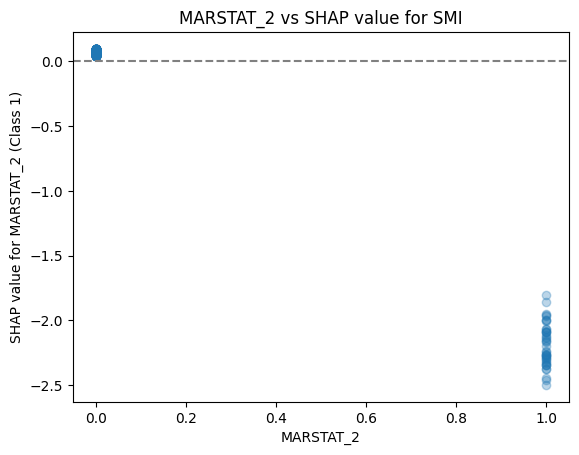

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["MARSTAT_2"], shap_df["MARSTAT_2"], alpha=0.3)
plt.xlabel("MARSTAT_2")
plt.ylabel("SHAP value for MARSTAT_2 (Class 1)")
plt.title("MARSTAT_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


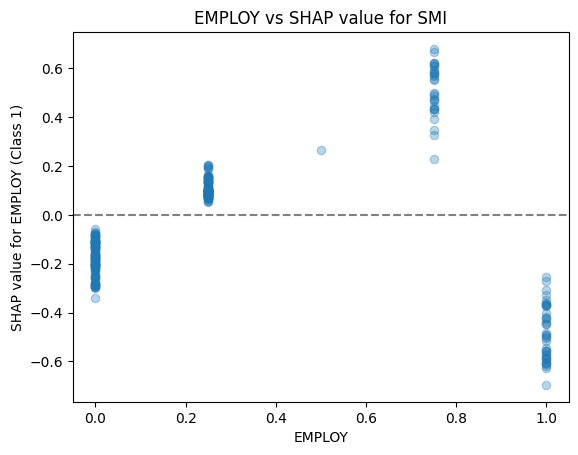

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 1)")
plt.title("EMPLOY vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
print(X['AGE'].describe())


count    1.147781e+06
mean     5.686161e-01
std      2.368219e-01
min      1.538462e-01
25%      3.846154e-01
50%      5.384615e-01
75%      7.692308e-01
max      1.000000e+00
Name: AGE, dtype: float64


In [ ]:
# 클래스2 SED SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


NUMMHS         0.177231
EDUC           0.172205
DETNLF_2       0.164574
SAP            0.082379
ALCSUBFLG      0.080288
EMPLOY         0.057419
GENDER         0.052148
TRAUSTREFLG    0.044522
MH3            0.038862
OPISERVICE     0.028517
dtype: float32


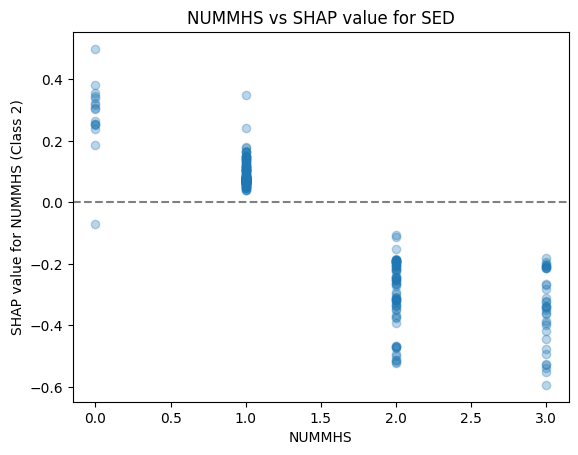

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS (Class 2)")
plt.title("NUMMHS vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


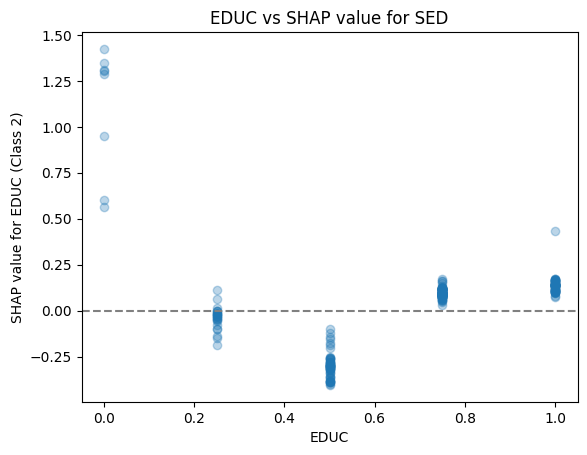

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDUC (Class 2)")
plt.title("EDUC vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


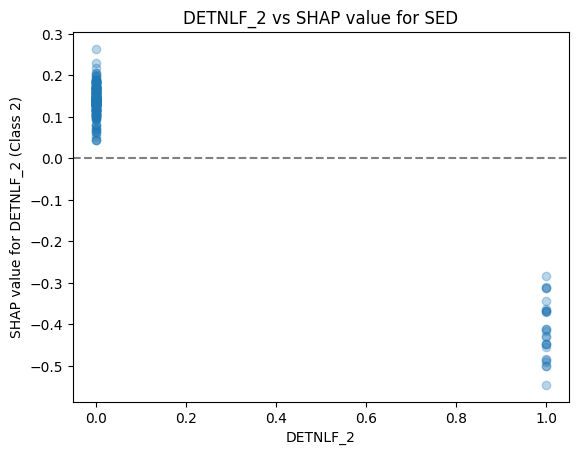

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 2)")
plt.title("DETNLF_2 vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# -------------------------------
# 1) 진단 관련 변수 제거
# -------------------------------
diagnosis_vars = [
    'MH1', 'MH2', 'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# -------------------------------
# 2) X, y 재정의
# -------------------------------
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# -------------------------------
# 3) 데이터셋 분리 (train/test)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------
# 4) SMOTE로 소수 클래스 Over-sampling
# -------------------------------
print("Before SMOTE:", y_train.value_counts().to_dict())
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", pd.Series(y_train_res).value_counts().to_dict())

# -------------------------------
# 5) XGBoost (class_weight은 XGBoost에서는 직접 weight로 제공)
# -------------------------------
# XGBoost에선 'scale_pos_weight'나 'sample_weight' 사용 가능
# multi-class라서 class weight 직접 전달 불가 -> SMOTE로 해결한 것만 사용

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)

model.fit(X_train_res, y_train_res)

# -------------------------------
# 6) 예측 및 정확도 평가
# -------------------------------
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Before SMOTE: {0: 670643, 2: 219519, 1: 28062}
After SMOTE: {0: 670643, 2: 670643, 1: 670643}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:09:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6865

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80    167661
           1       0.27      0.90      0.42      7016
           2       0.43      0.42      0.43     54880

    accuracy                           0.69    229557
   macro avg       0.51      0.69      0.55    229557
weighted avg       0.72      0.69      0.70    229557



In [ ]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/단순결측치 행 제거.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


전체적으로 단순 결측값 데이터셋, 결측값 모두 제거한 데이터셋 두개를 돌렸을 때 SMISED와 각 FEATURE들의 관계성은 비슷하게 나타남.

In [ ]:
# 단순결측치 행 제거로 돌린 통계적 차이 검정

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)


ANOVA for AGE
                  sum_sq         df             F  PR(>F)
C(SMISED)  213562.163671        2.0  1.939641e+06     0.0
Residual   292744.796399  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.5389   0.0 -0.5395 -0.5382   True
     1      3  -0.1577   0.0 -0.1583 -0.1572   True
     2      3   0.3811   0.0  0.3804  0.3819   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)  4.698579e+05        2.0  10263.551572     0.0
Residual   1.217181e+08  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.7943   0.0 -0.8074 -0.7812   True
     1      3  -0.1142   0.0 -0.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

numeric_ = ["AGE", "EDUC", "NUMMHS"]
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]
target = "SMISED"

anova_results = []
tukey_results = []
chi2_results = []

for variable in numeric_:
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    F = anova_table.loc[f"C({target})", "F"]
    pval = anova_table.loc[f"C({target})", "PR(>F)"]
    anova_results.append({
        "Variable": variable,
        "F-stat": F,
        "p-value": pval
    })

    tukey = pairwise_tukeyhsd(df[variable], df[target])
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_df["Variable"] = variable
    tukey_results.append(tukey_df)

for var in categorical:
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    chi2_results.append({
        "Variable": var,
        "Chi2": chi2,
        "p-value": p,
        "DoF": dof
    })


anova_df = pd.DataFrame(anova_results)
tukey_df = pd.concat(tukey_results, ignore_index=True)
chi2_df = pd.DataFrame(chi2_results)


print("\n[ANOVA Table]")
print(anova_df)

print("\n[Tukey HSD]")
print(tukey_df)

print("\n[Chi-square Table]")
print(chi2_df)




[ANOVA Table]
  Variable        F-stat  p-value
0      AGE  1.939641e+06      0.0
1     EDUC  1.026355e+04      0.0
2   NUMMHS  3.130389e+04      0.0

[Tukey HSD]
   group1  group2  meandiff  p-adj   lower   upper  reject Variable
0       1       2   -0.5389    0.0 -0.5395 -0.5382    True      AGE
1       1       3   -0.1577    0.0 -0.1583 -0.1572    True      AGE
2       2       3    0.3811    0.0  0.3804  0.3819    True      AGE
3       1       2   -0.7943    0.0 -0.8074 -0.7812    True     EDUC
4       1       3   -0.1142    0.0 -0.1257 -0.1027    True     EDUC
5       2       3    0.6801    0.0  0.6653  0.6949    True     EDUC
6       1       2   -0.0757    0.0 -0.0779 -0.0735    True   NUMMHS
7       1       3   -0.2081    0.0 -0.2100 -0.2061    True   NUMMHS
8       2       3   -0.1324    0.0 -0.1349 -0.1299    True   NUMMHS

[Chi-square Table]
      Variable          Chi2        p-value  DoF
0       ETHNIC  6.522410e+04   0.000000e+00    6
1         RACE  9.530195e+04   0.00000

**AGE**	1 < 2 < 3	SMISED 높을수록 나이 증가

**EDUC** 	3번 그룹(중증)의 교육 수준 매우 낮음

**NUMMHS**	서비스 많이 이용한 그룹들이 있어보이나, 그렇게 연관성이 커보이지는 않음

**ETHNIC** 인종/민족으로 차이가 있어보임

**RACE** 인종

**GENDER** 남/녀 비율 다름

**SPHSERVICE** SMISED가 높을수록 이용 증가

**CMPSERVICE**	일부 그룹만 이용

**OPISERVICE**	외래 서비스 차이 큼	접근성 or 서비스 패턴 차이

**RTCSERVICE** 조금 약한데, 그래도 차이 있어보임

**SUB (Substance Use)**	정신질환과 약물 사용 연관성 있음

**MARSTAT (결혼상태)** 미혼 or 이혼 그룹에서 많음

**EMPLOY**	무직 비율이 높음

          SMISED가 높을수록 고용률 낮음

**DETNLF**	경제활동 인구나 노동 참여 관련

**VETERAN**	 군복무 경험 여부

**LIVARAG** 동거 여부

**DIVISION** 지역 간 분포 다름
          
          얘 또한 지역별 차이로, 정책이나 지원을 반영했거나
          우리의 전처리 과정에서의 차이일 수 있을 것

**REGION**	북동/남부 등 차이 존재

          이것 또한 결측치 많은 지역들이 삭제되어 데이터 전체에 영향을 주었을 기능성이 있어 보임

**STATEFIP**	주별 분포 다름	데이터 구조상 영향 큼

          주별로 결측치가 많은 주가 삭제되어서 그런지, 데이터 자체의 차이가 큰 것 같음.
          + 변수 개수 많아 원핫 주의


In [ ]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'DIVISION', 'REGION', 'CASEID']


In [ ]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
drive.mount('/content/drive')

# 1. 데이터 불러오기
file_path = '/content/drive/MyDrive/결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'DIVISION', 'REGION', 'CASEID']


In [ ]:
# 모든 결측치 제거한 데이터셋 활용 분석

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)



ANOVA for AGE
                 sum_sq         df             F  PR(>F)
C(SMISED)   7627.331877        2.0  77138.201968     0.0
Residual   56745.448452  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.4482   0.0  -0.451 -0.4453   True
     1      3  -0.0824   0.0 -0.0835 -0.0812   True
     2      3   0.3658   0.0  0.3628  0.3687   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)   2947.253697        2.0  28502.441533     0.0
Residual   59342.161098  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.2702   0.0 -0.2731 -0.2673   True
     1      3  -0.0593   0.0 -0.060

 (0=해당없음, 1=SMI, 2=SED)

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

In [ ]:

pd.set_option('display.max_columns', None)
df.head(10)

,YEAR,AGE,EDUC,GENDER,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,IJSSERVICE,MH1,MH2,MH3,SAP,EMPLOY,VETERAN,NUMMHS,TRAUSTREFLG,ANXIETYFLG,ADHDFLG,CONDUCTFLG,DELIRDEMFLG,BIPOLARFLG,DEPRESSFLG,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG,STATEFIP,CASEID,RACE_2,RACE_3,RACE_4,RACE_5,RACE_6,ETHNIC_2,ETHNIC_3,ETHNIC_4,REGION_1,REGION_2,REGION_3,REGION_4,SUB_1,SUB_2,SUB_3,SUB_4,SUB_5,SUB_6,SUB_7,SUB_8,SUB_9,SUB_10,SUB_11,SUB_12,SUB_13,MARSTAT_2,MARSTAT_3,MARSTAT_4,SMISED_2,SMISED_3,DETNLF_2,DETNLF_3,DETNLF_4,DETNLF_5,DETNLF_NotApplicable,LIVARAG_2,LIVARAG_3,DIVISION_1,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9
0,2022,0.461538,0.50,1,0,1,0,0,0,7,11,-99,1,0.25,0,2,0,0,0,0,0,0,1,0,0,0,1,0,0,1,20220000002,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
1,2022,1.000000,0.75,0,1,1,0,0,0,11,-99,-99,2,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,20220000004,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
2,2022,0.615385,1.00,0,0,1,1,0,0,7,1,2,1,0.00,0,3,1,1,0,0,0,0,1,0,0,0,0,0,0,1,20220000013,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,2022,0.615385,1.00,0,0,1,1,0,0,7,-99,-99,2,1.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000025,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
4,2022,0.846154,0.50,0,0,1,0,0,0,6,-99,-99,1,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000029,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
5,2022,0.538462,0.50,1,0,1,0,0,0,6,13,-99,1,0.00,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,1,20220000031,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
6,2022,0.461538,1.00,0,0,1,0,0,0,2,-99,-99,2,1.00,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,20220000033,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
7,2022,0.692308,0.75,0,0,1,0,0,0,7,-99,-99,2,0.25,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000034,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
8,2022,0.384615,0.75,1,0,1,0,0,0,6,-99,-99,2,1.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000038,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
9,2022,0.846154,0.75,0,0,1,1,0,0,11,-99,-99,2,0.25,0,1,0,0,0,0,0,0,0

In [ ]:
print(df.columns.tolist())

['YEAR', 'AGE', 'EDUC', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SAP', 'EMPLOY', 'VETERAN', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'CASEID', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2', 'ETHNIC_3', 'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9', 'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'MARSTAT_2', 'MARSTAT_3', 'MARSTAT_4', 'SMISED_2', 'SMISED_3', 'DETNLF_2', 'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable', 'LIVARAG_2', 'LIVARAG_3', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9']


### **Random Forest 기반, 모든 변수 포함**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.7623


PermutationExplainer explainer: 301it [01:32,  3.05it/s]


None


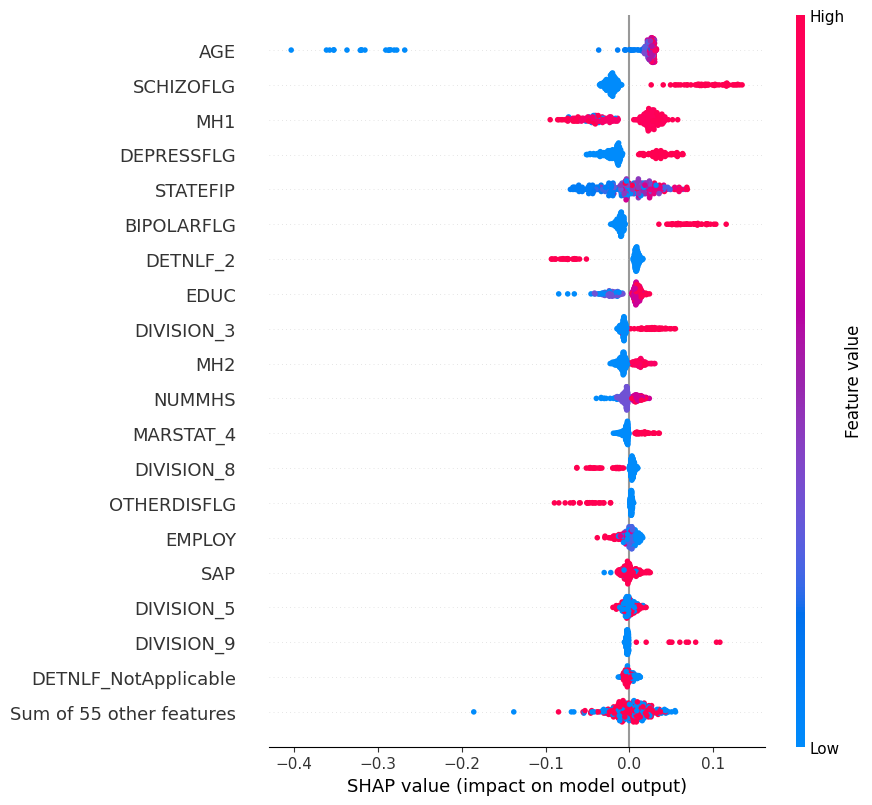

SMI


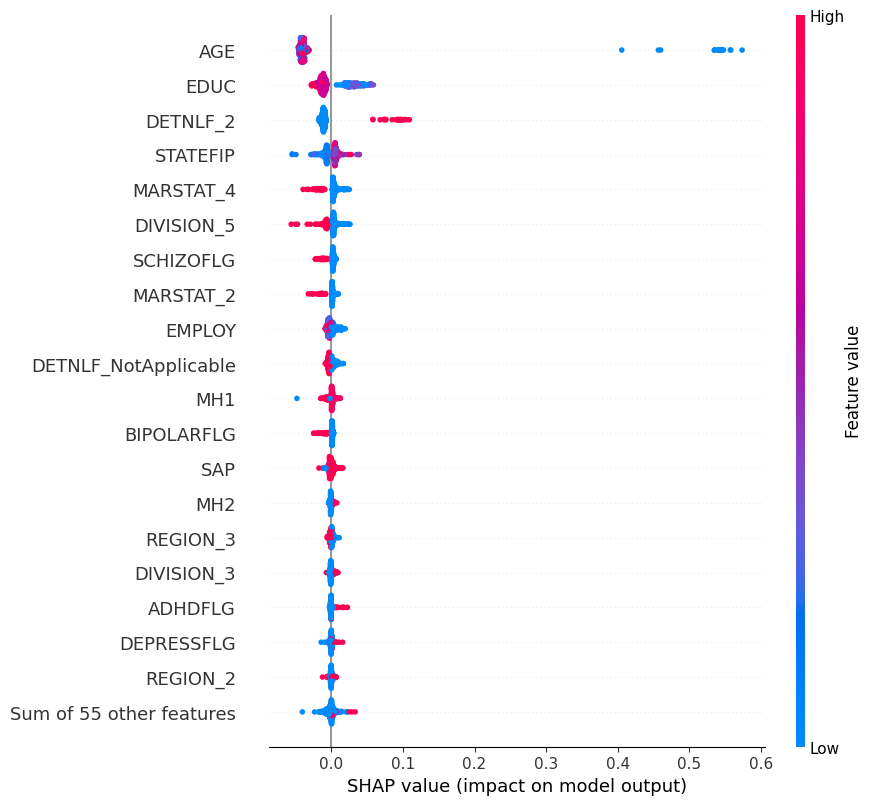

SED


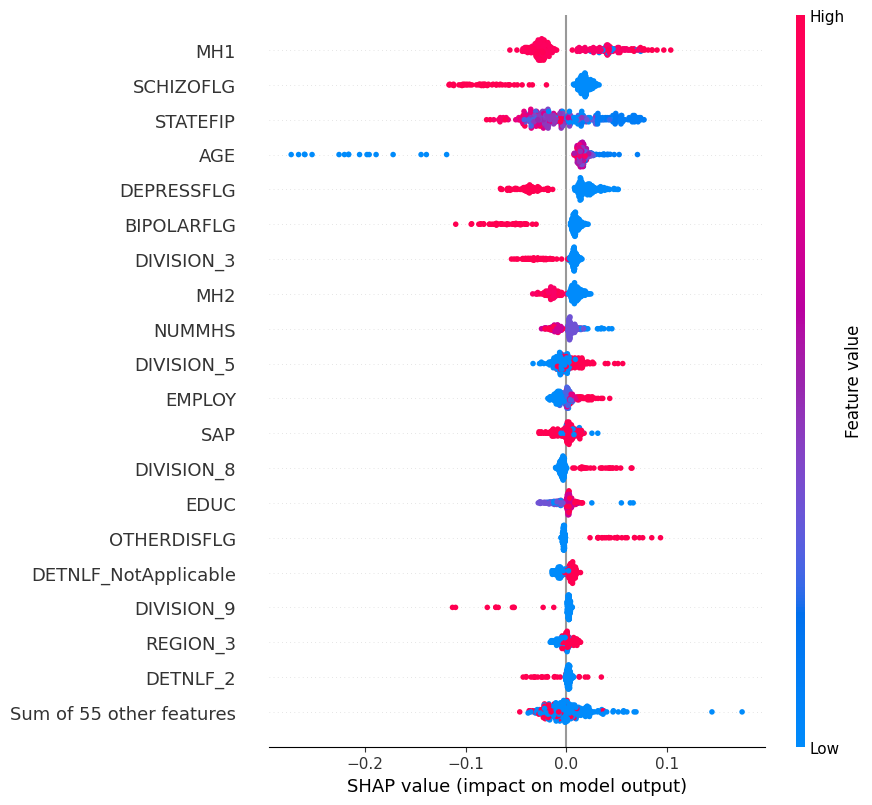

In [ ]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# SMISED 타겟 컬럼 생성 (0=해당없음, 1=SMI, 2=SED)
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0), axis=1)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype(float)

# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)

# 시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.90      0.78      0.84    838304
         SMI       0.67      1.00      0.80     35078
         SED       0.50      0.66      0.57    274399

    accuracy                           0.76   1147781
   macro avg       0.69      0.82      0.74   1147781
weighted avg       0.80      0.76      0.77   1147781



In [ ]:
# 클래스0 증상 없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df4 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df4.abs().mean().sort_values(ascending=False)
importance.head(10)

,0
AGE,0.041041
SCHIZOFLG,0.034750
MH1,0.033754
DEPRESSFLG,0.025814
STATEFIP,0.024370
BIPOLARFLG,0.020945
DETNLF_2,0.014456
EDUC,0.014193
DIVISION_3,0.011631
MH2,0.010206


In [ ]:
# 클래스1 SMI SHAP 값
shap_values_class1 = shap_values[:, :, 1].values

df2 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df2.abs().mean().sort_values(ascending=False)
print(importance.head(10))


AGE                     0.068660
EDUC                    0.019339
DETNLF_2                0.017696
STATEFIP                0.008099
MARSTAT_4               0.007242
DIVISION_5              0.006430
SCHIZOFLG               0.004429
MARSTAT_2               0.003745
EMPLOY                  0.003704
DETNLF_NotApplicable    0.003387
dtype: float64


In [ ]:
# 클래스2 SED SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

MH1           0.033263
SCHIZOFLG     0.030321
STATEFIP      0.029712
AGE           0.028055
DEPRESSFLG    0.026456
BIPOLARFLG    0.018181
DIVISION_3    0.012779
MH2           0.011661
NUMMHS        0.008551
DIVISION_5    0.008459
dtype: float64


### 클래스 0
age, schizoflg, mh1, depressflg, stateip 순.

연령, 조현병 진단 여부, 주진단코드의 여부, 우울증 여부,state 정보가 정신질환에 큰 영향을 줌.

### 클래스 1 (중증 정신질환)

age, educ, detnlf_2, stateip, marstat_4

연령(낮을수록), 교육수준(낮을수록), 경제활동(없을수록), 지역적 차이, 결혼상태(불안정)

### 클래스 2 (심한 정서질환)
mh1, schizoflg, stateip, age, depresflg

SED에 해당하는 특정 진단 코드, 조현병 진단 여부, 거주지, 나이(청소년일수록), 우울증 진단 여부

### **진단 관련 변수 미포함 랜덤포레스트**

Accuracy: 0.7194


PermutationExplainer explainer: 301it [01:36,  2.77it/s]


None


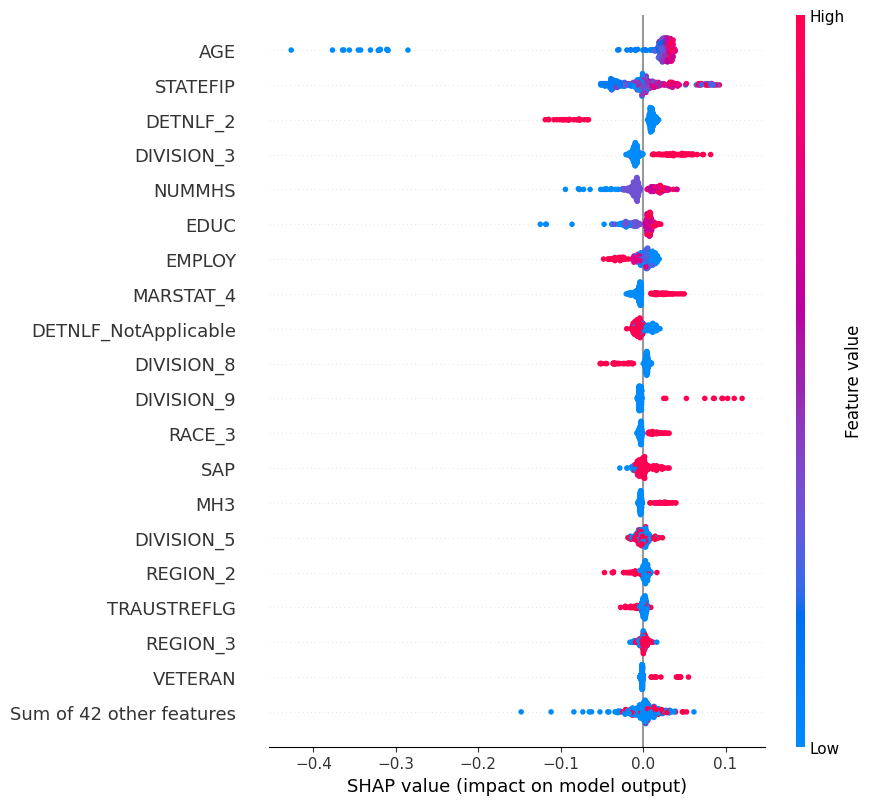

SMI


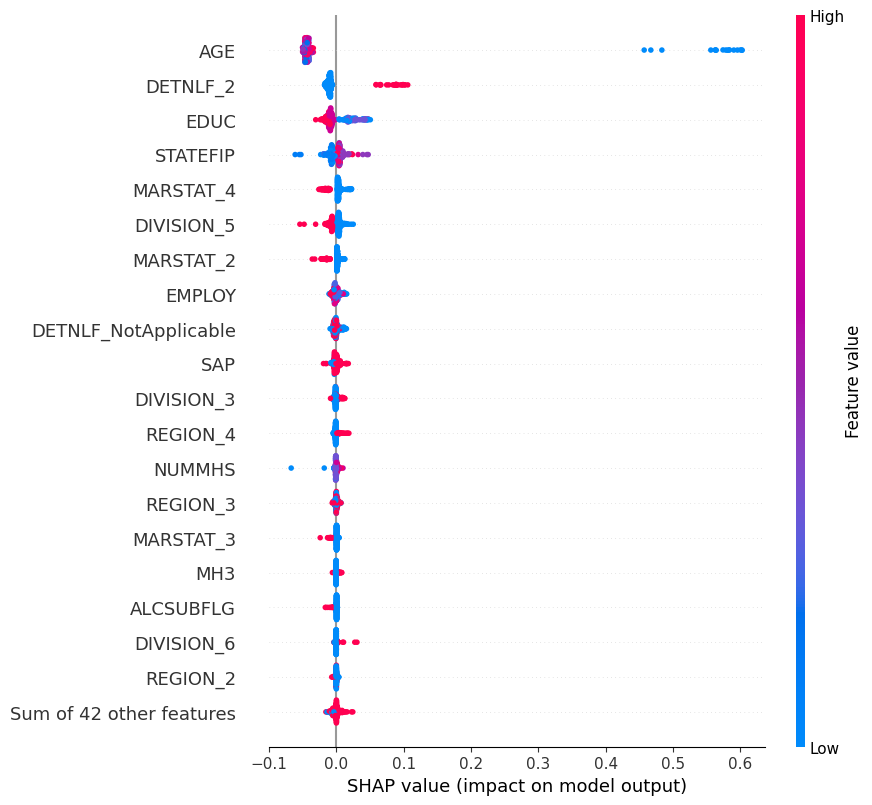

SED


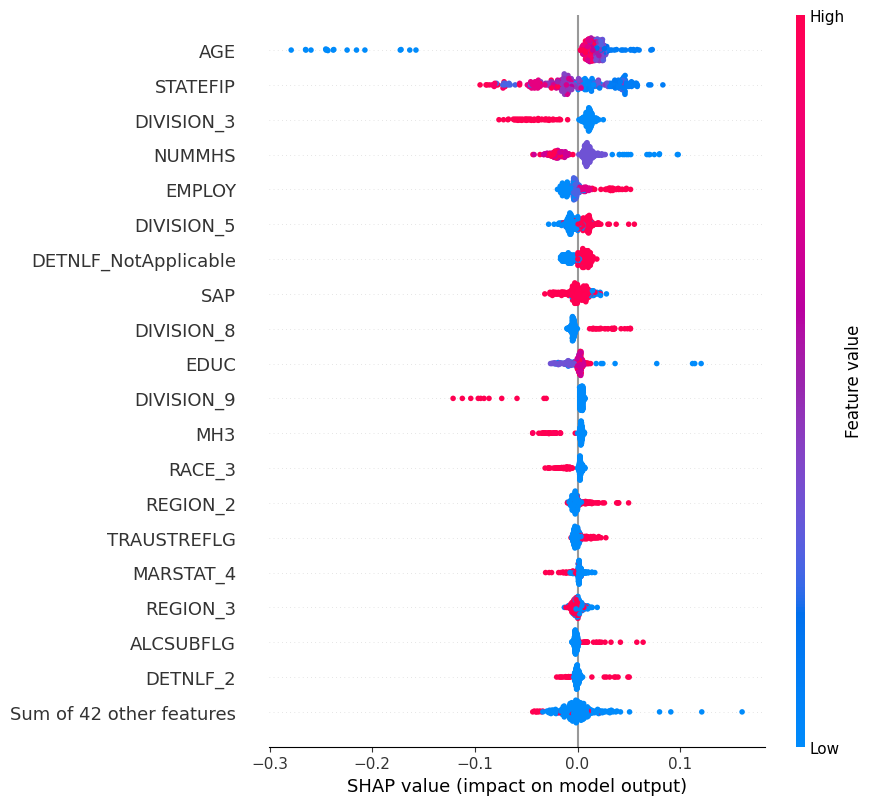

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)


# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.88      0.74      0.80    838304
         SMI       0.65      1.00      0.79     35078
         SED       0.44      0.61      0.51    274399

    accuracy                           0.72   1147781
   macro avg       0.65      0.78      0.70   1147781
weighted avg       0.76      0.72      0.73   1147781



In [ ]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.044186
STATEFIP                0.023470
DETNLF_2                0.017550
DIVISION_3              0.016146
NUMMHS                  0.015540
EDUC                    0.011978
EMPLOY                  0.009643
MARSTAT_4               0.009228
DETNLF_NotApplicable    0.007478
DIVISION_8              0.007352
dtype: float64


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.073160
DETNLF_2                0.016889
EDUC                    0.015098
STATEFIP                0.007408
MARSTAT_4               0.006296
DIVISION_5              0.006145
MARSTAT_2               0.003949
EMPLOY                  0.003201
DETNLF_NotApplicable    0.002894
SAP                     0.002569
dtype: float64


In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.029938
STATEFIP                0.028711
DIVISION_3              0.017936
NUMMHS                  0.016787
EMPLOY                  0.010036
DIVISION_5              0.008152
DETNLF_NotApplicable    0.007843
SAP                     0.007754
DIVISION_8              0.007169
EDUC                    0.006804
dtype: float64


### 클래스0 (정신장애 없음)



### **지역변수도 함께 제거한 랜덤포레스트**

상위 5개만 가지고 확인 중인데, 모두 질환제거했을 때와 항목은 동일

In [ ]:
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

Accuracy: 0.7017


PermutationExplainer explainer: 301it [01:56,  2.34it/s]


None


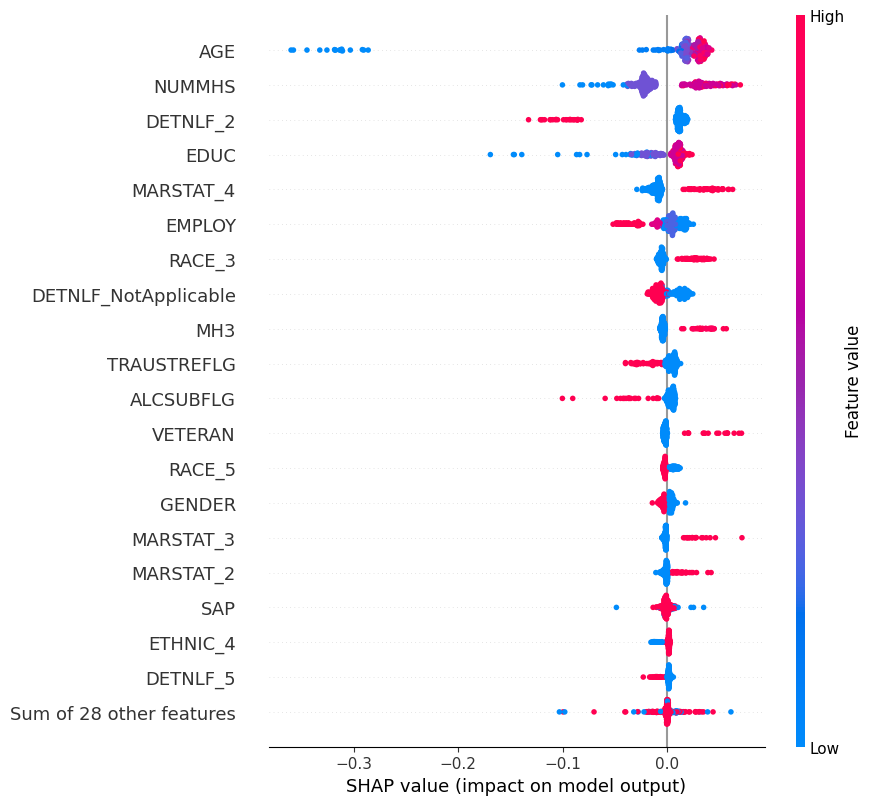

SMI


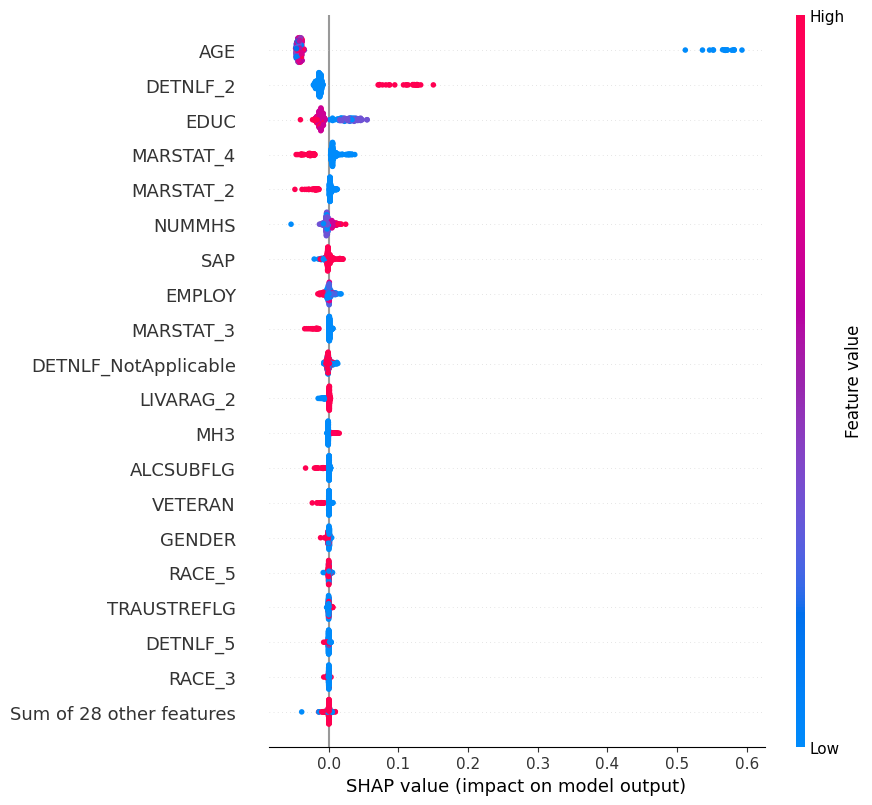

SED


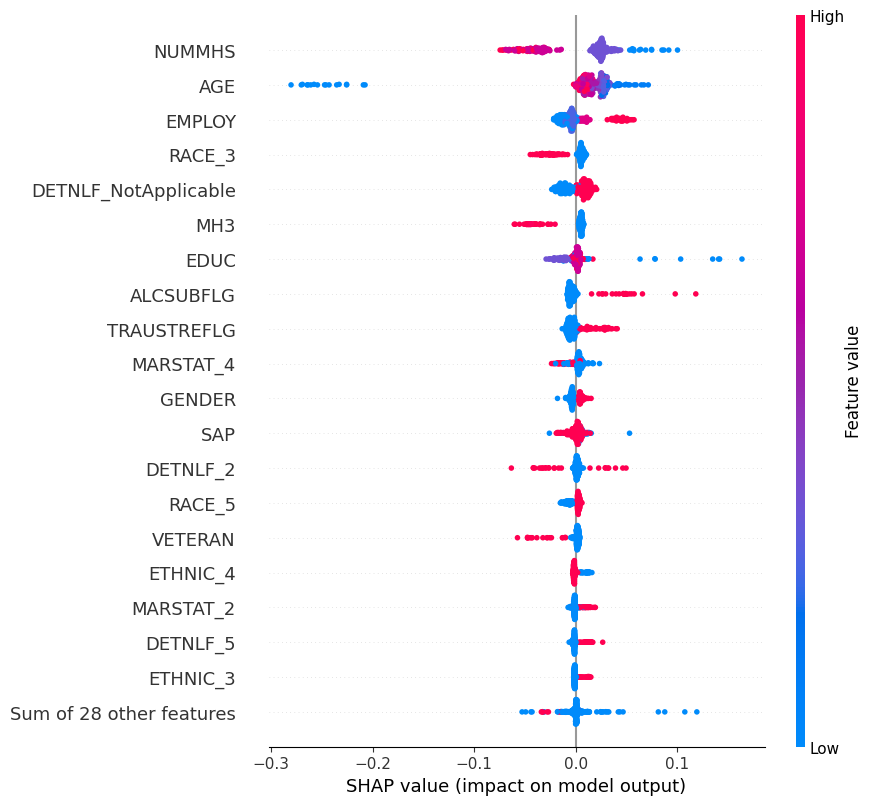

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 지역 변수도 추가로 제거
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# 지역 변수 제거 이후 X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)
# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# 11. SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 14. 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

In [ ]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.041235
NUMMHS                  0.029746
DETNLF_2                0.019789
EDUC                    0.016098
MARSTAT_4               0.015646
EMPLOY                  0.011786
RACE_3                  0.010587
DETNLF_NotApplicable    0.009918
MH3                     0.008056
TRAUSTREFLG             0.007608
dtype: float64


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.072490
DETNLF_2                0.021870
EDUC                    0.017370
MARSTAT_4               0.011591
MARSTAT_2               0.005352
NUMMHS                  0.004182
SAP                     0.003078
EMPLOY                  0.003008
MARSTAT_3               0.002768
DETNLF_NotApplicable    0.002075
dtype: float64


In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

NUMMHS                  0.033917
AGE                     0.032103
EMPLOY                  0.013037
RACE_3                  0.010407
DETNLF_NotApplicable    0.010159
MH3                     0.009661
EDUC                    0.008358
ALCSUBFLG               0.007387
TRAUSTREFLG             0.007187
MARSTAT_4               0.005166
dtype: float64


### **클래스 0 (해당 없음)**
**AGE, NUMMHS, DETNLF_2, EDUC, MARTAT_4**

연령(많을수록), NUMMHS(적음), DETNLF_2(양호), EDUC(높음), MARSTAT_4(가족이 안정됨)

---

### **클래스1 (SMI)**
**AGE, DETNLF_2, EDUC, MARSTAT_4, MARSTAT_2**

연령(낮음), EDUC(낮음), DETNLF_2(실업), MARSTAT - 가족이 불안정함

---

### **클래스 2 (SED)**
**NUMMHS, AGE, EMPLOY, DETNLF_NotApplicable, RACE_3**

AGE(청소년층), NUMMHS(서비스 다수 이용), EMPLOY(경제활동 미참여), DETNLF_(고용상태 불안정), RACE_3(인종)

### **XGBOOST : 모든 변수 포함**


랜덤포레스트와의 정확도 비교 위하여 XGBOOST행

In [ ]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 데이터 다시 불러오기
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# 데이터 처리
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:39:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8494


In [ ]:
print(type(shap_values))
print(len(shap_values))           # 클래스 개수?
print(shap_values[0].shape)       # 클래스 0에 대한 SHAP 값 shape
print(X_sample.shape)             # 피처 샘플 shape


<class 'shap._explanation.Explanation'>
300
(47, 3)
(300, 47)



클래스 0 (None)


/tmp/ipython-input-36-1764749090.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


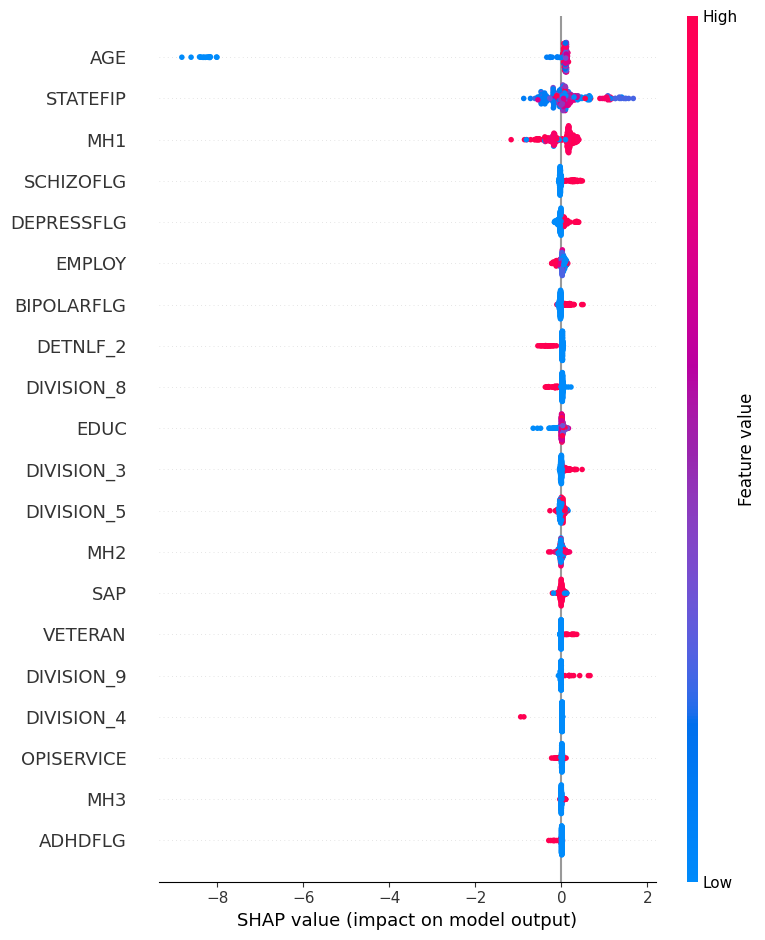


클래스 1 (SMI)


/tmp/ipython-input-36-1764749090.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


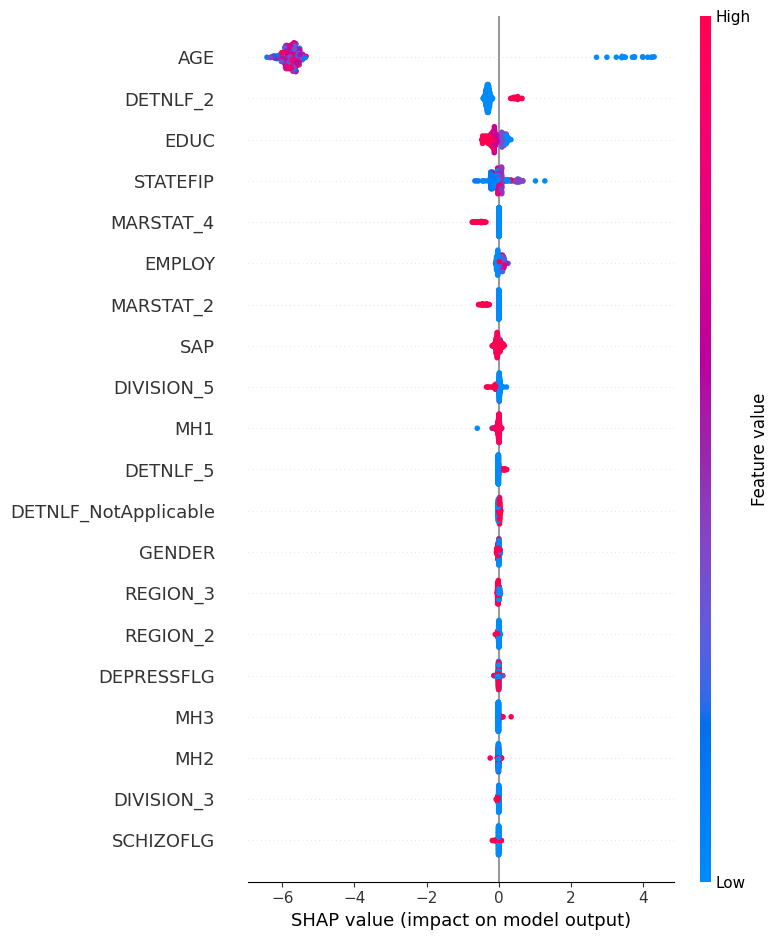


클래스 2 (SED)


/tmp/ipython-input-36-1764749090.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


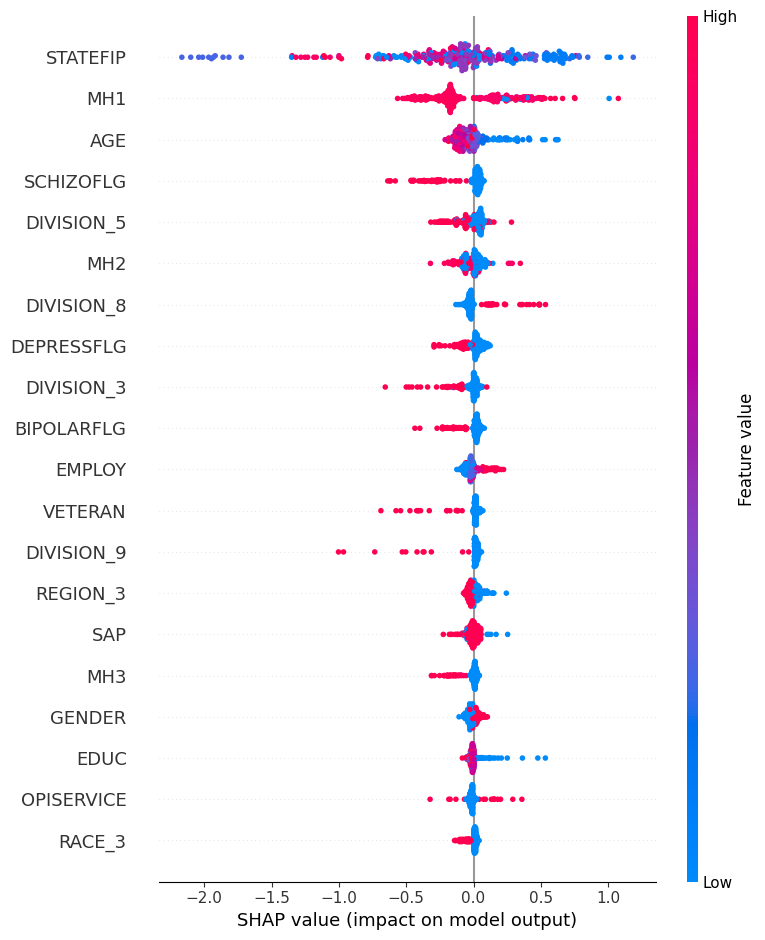

In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  # 3 classes: 0=None, 1=SMI, 2=SED
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]

    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
print((X_sample.size))

22200


In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE           0.570559
STATEFIP      0.293030
MH1           0.230329
SCHIZOFLG     0.069946
DEPRESSFLG    0.054661
EMPLOY        0.052685
BIPOLARFLG    0.050195
DETNLF_2      0.045879
DIVISION_8    0.041741
EDUC          0.037737
dtype: float32


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

AGE           5.648525
DETNLF_2      0.313364
EDUC          0.179782
STATEFIP      0.138999
MARSTAT_4     0.100917
EMPLOY        0.076296
MARSTAT_2     0.063513
SAP           0.051864
DIVISION_5    0.044346
MH1           0.022959
dtype: float32


In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

STATEFIP      0.403794
MH1           0.253603
AGE           0.088795
SCHIZOFLG     0.084895
DIVISION_5    0.060868
MH2           0.055018
DIVISION_8    0.052614
DEPRESSFLG    0.051533
DIVISION_3    0.047415
BIPOLARFLG    0.045978
dtype: float32


### XGBoost: 진단 미포함

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:56:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7742


<class 'numpy.ndarray'>
300
(61, 3)
(300, 61)

클래스 0 (None)


/tmp/ipython-input-42-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


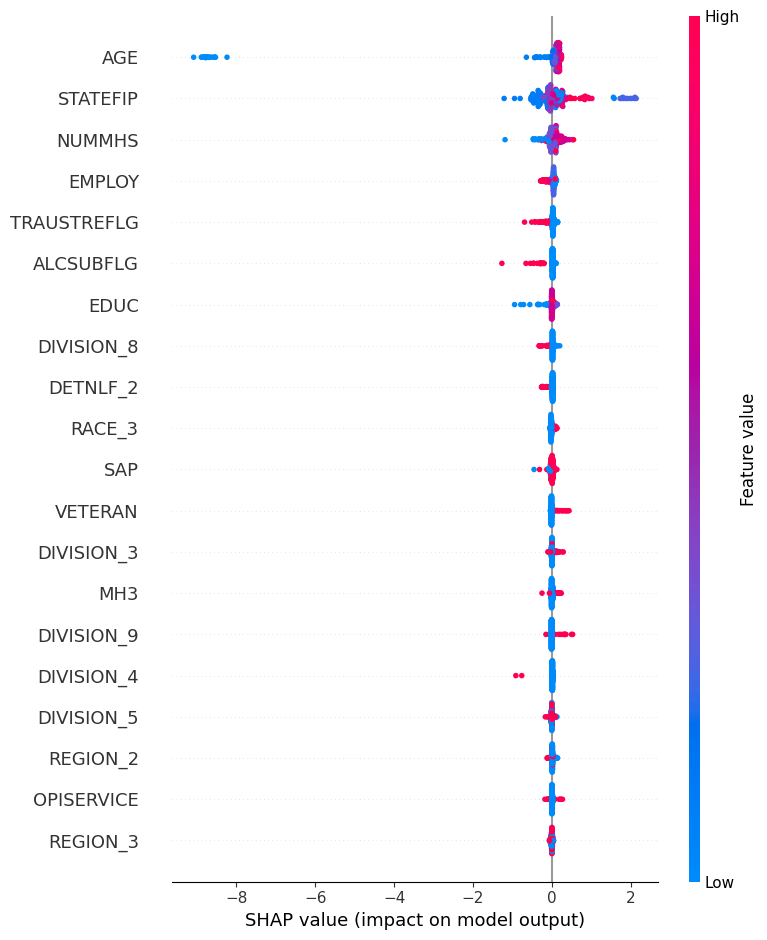


클래스 1 (SMI)


/tmp/ipython-input-42-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


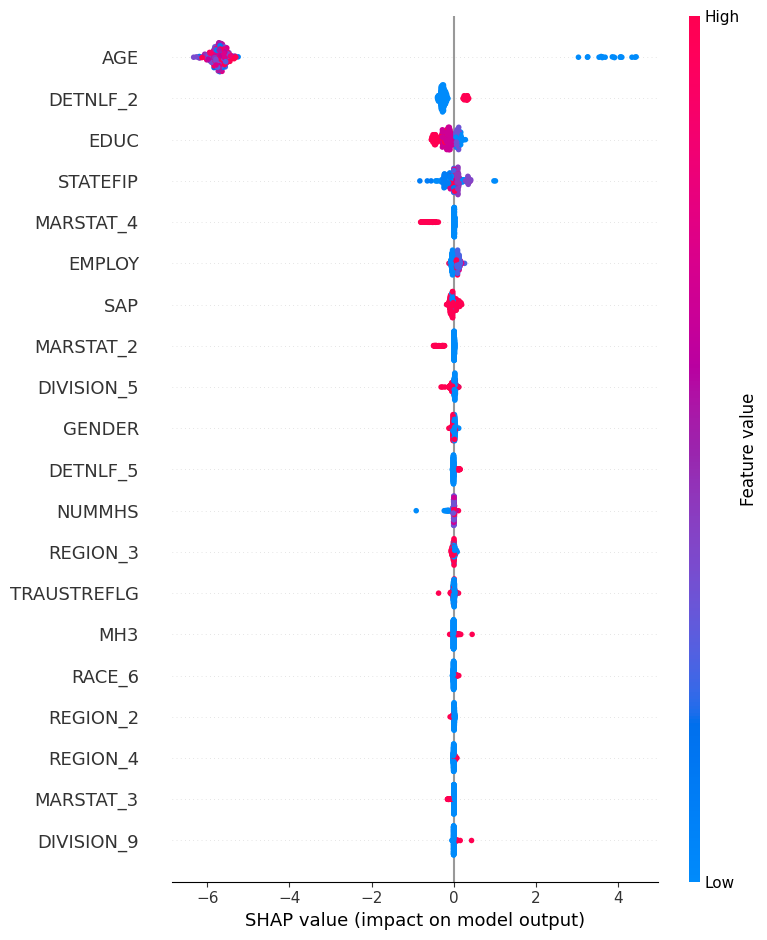


클래스 2 (SED)


/tmp/ipython-input-42-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


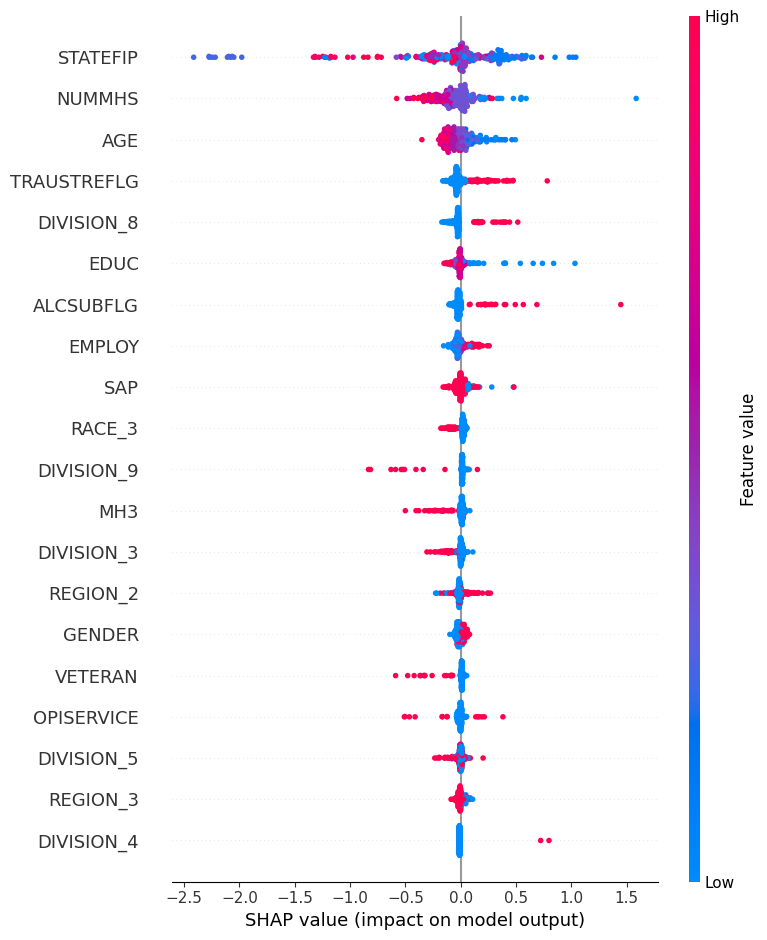

In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.79      0.96      0.87    838304
         SMI       0.55      0.48      0.51     35078
         SED       0.66      0.23      0.34    274399

    accuracy                           0.77   1147781
   macro avg       0.67      0.56      0.57   1147781
weighted avg       0.75      0.77      0.73   1147781



In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE            0.626797
STATEFIP       0.297713
NUMMHS         0.114436
EMPLOY         0.063733
TRAUSTREFLG    0.057283
ALCSUBFLG      0.047471
EDUC           0.044922
DIVISION_8     0.039770
DETNLF_2       0.030535
RACE_3         0.028112
dtype: float32


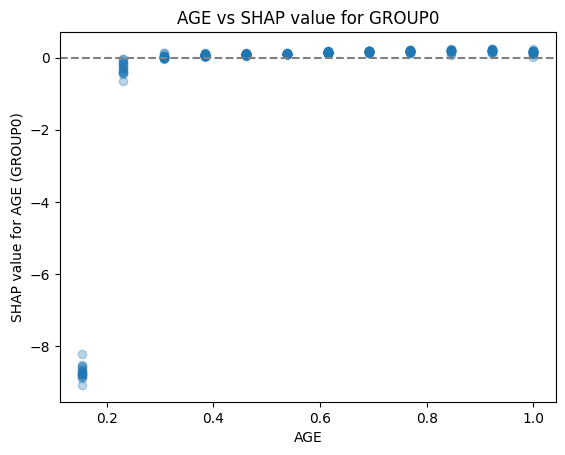

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (GROUP0)")
plt.title("AGE vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


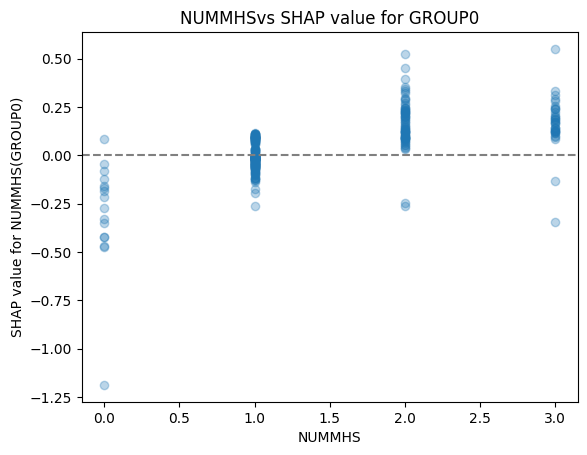

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS(GROUP0)")
plt.title("NUMMHSvs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


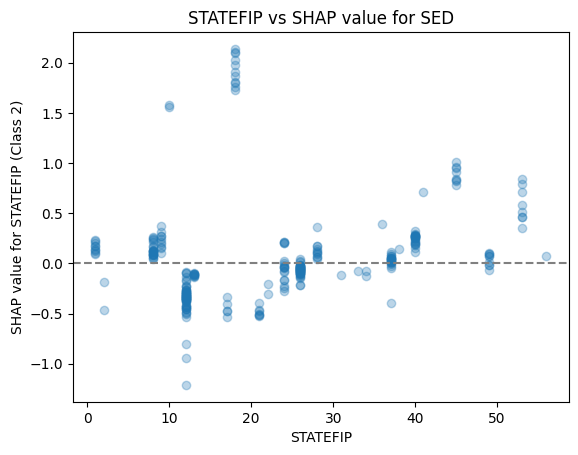

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["STATEFIP"], shap_df["STATEFIP"], alpha=0.3)
plt.xlabel("STATEFIP")
plt.ylabel("SHAP value for STATEFIP (Class 2)")
plt.title("STATEFIP vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE           5.604999
DETNLF_2      0.274204
EDUC          0.180668
STATEFIP      0.128890
MARSTAT_4     0.111715
EMPLOY        0.074925
SAP           0.062416
MARSTAT_2     0.060142
DIVISION_5    0.038075
GENDER        0.022304
dtype: float32


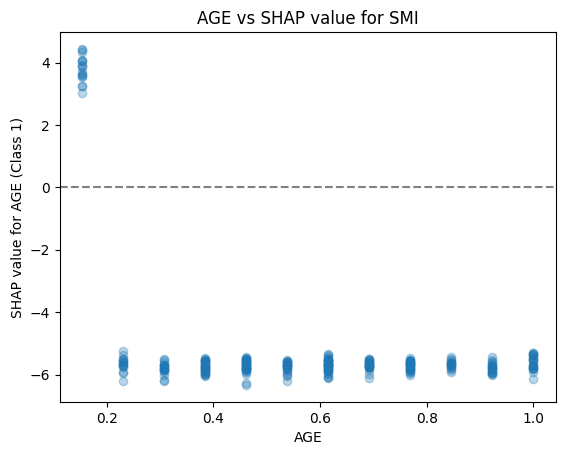

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


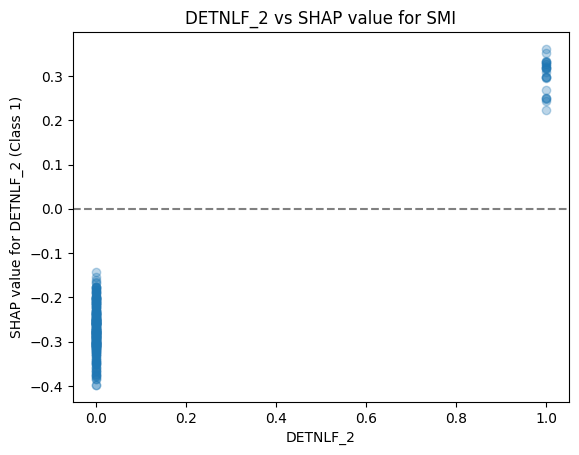

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

STATEFIP       0.335400
NUMMHS         0.132664
AGE            0.097197
TRAUSTREFLG    0.076237
DIVISION_8     0.059599
EDUC           0.049129
ALCSUBFLG      0.047503
EMPLOY         0.043391
SAP            0.038386
RACE_3         0.037772
dtype: float32


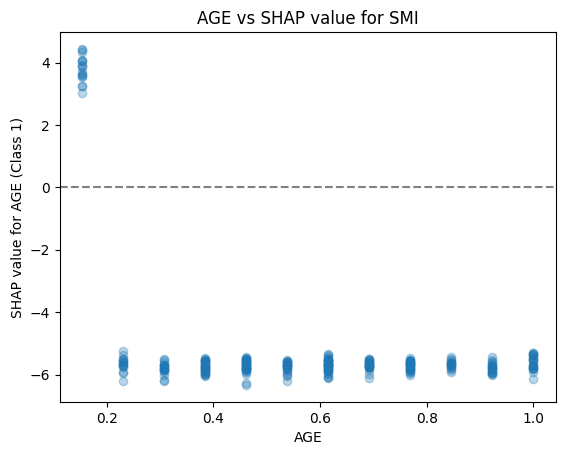

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


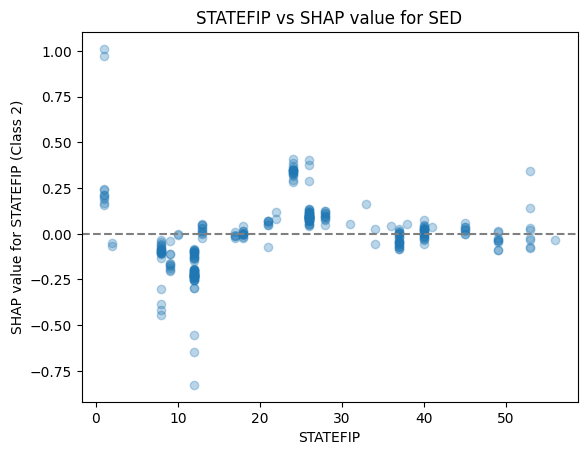

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["STATEFIP"], shap_df["STATEFIP"], alpha=0.3)
plt.xlabel("STATEFIP")
plt.ylabel("SHAP value for STATEFIP (Class 2)")
plt.title("STATEFIP vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


### XGBoost: 진단+지역변수 미포함

In [ ]:
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG','OTHERDISFLG'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7742


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.79      0.96      0.87    838304
         SMI       0.55      0.48      0.51     35078
         SED       0.66      0.23      0.34    274399

    accuracy                           0.77   1147781
   macro avg       0.67      0.56      0.57   1147781
weighted avg       0.75      0.77      0.73   1147781



<class 'numpy.ndarray'>
300
(47, 3)
(300, 47)

클래스 0 (None)


/tmp/ipython-input-55-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


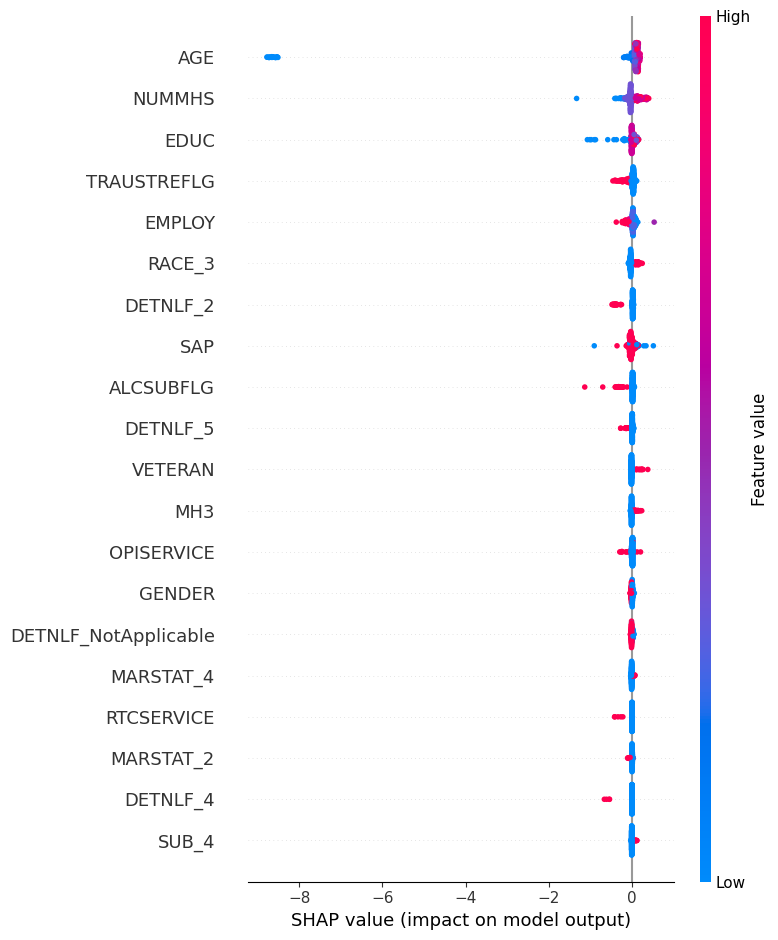


클래스 1 (SMI)


/tmp/ipython-input-55-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


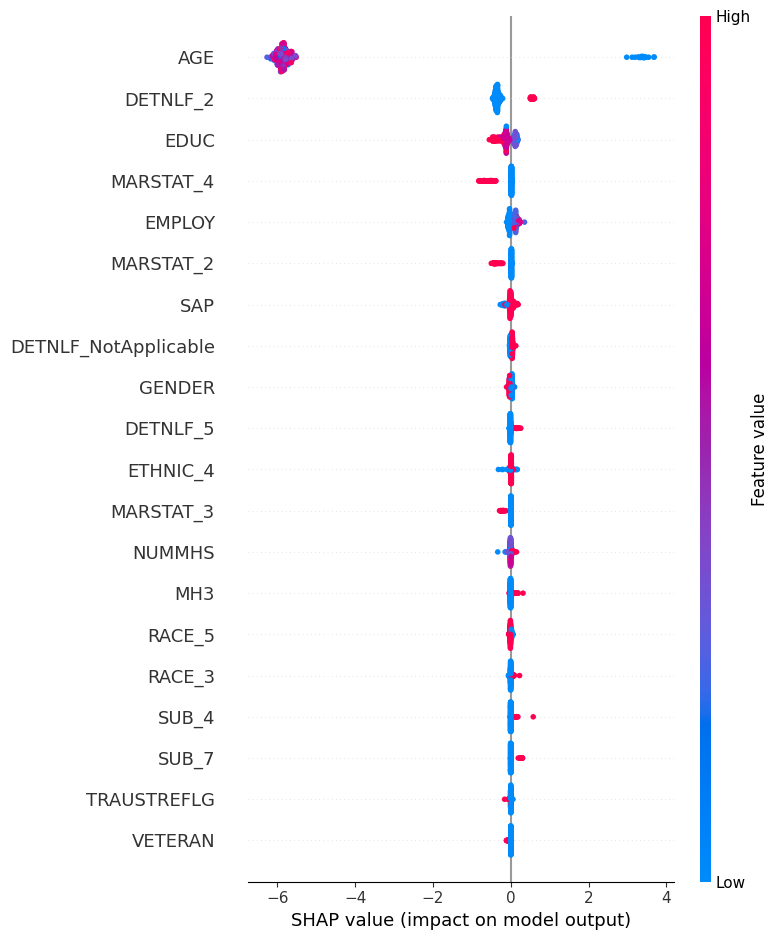


클래스 2 (SED)


/tmp/ipython-input-55-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


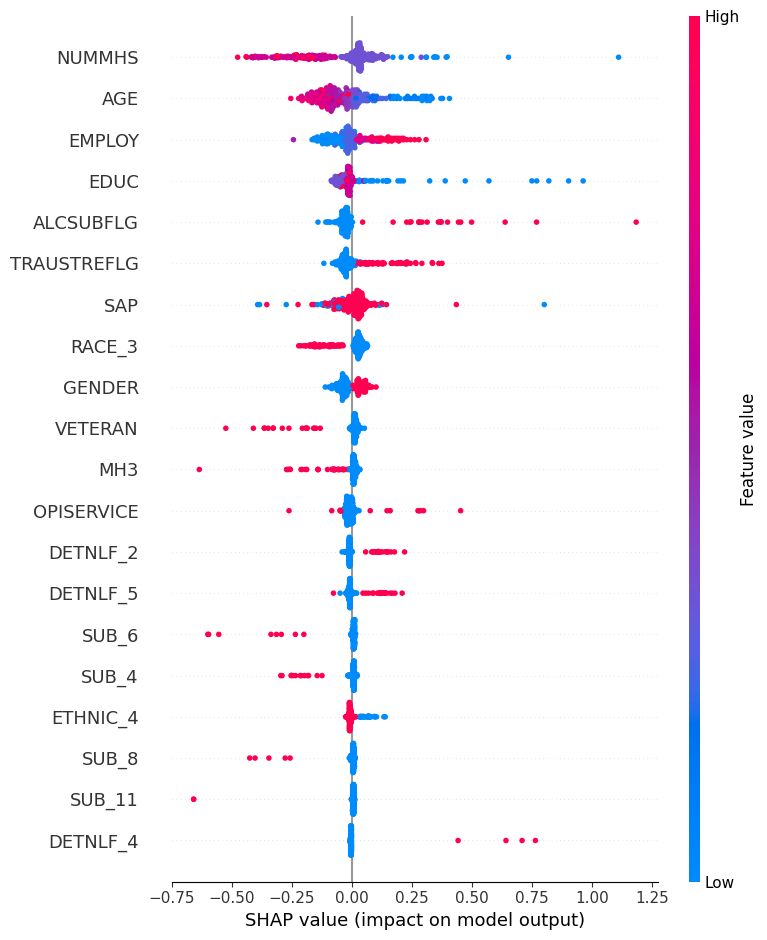

In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

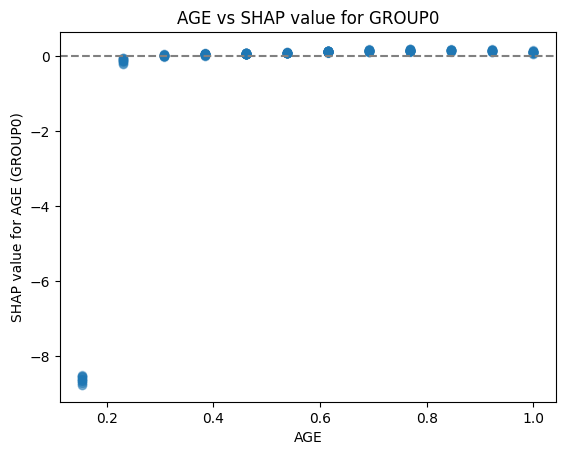

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (GROUP0)")
plt.title("AGE vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


### AGE까지 제거###

In [ ]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 데이터 다시 불러오기
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)


# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'OTHERDISFLG', 'AGE'
]

region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# 데이터 처리
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7742


<class 'numpy.ndarray'>
300
(46, 3)
(300, 46)

클래스 0 (None)


/tmp/ipython-input-58-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


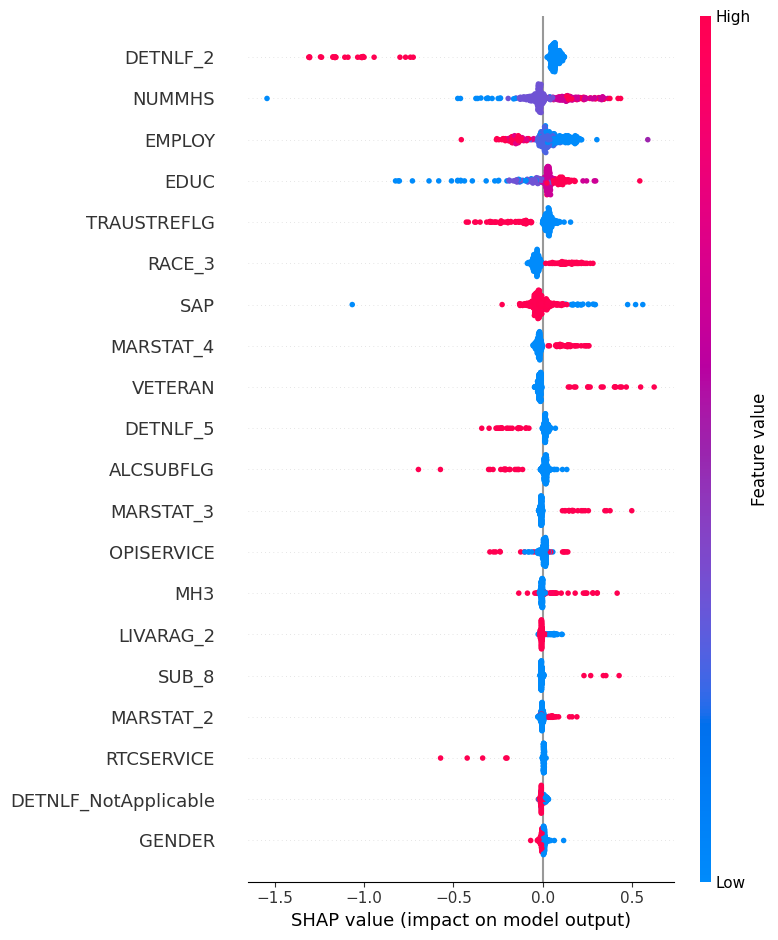


클래스 1 (SMI)


/tmp/ipython-input-58-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


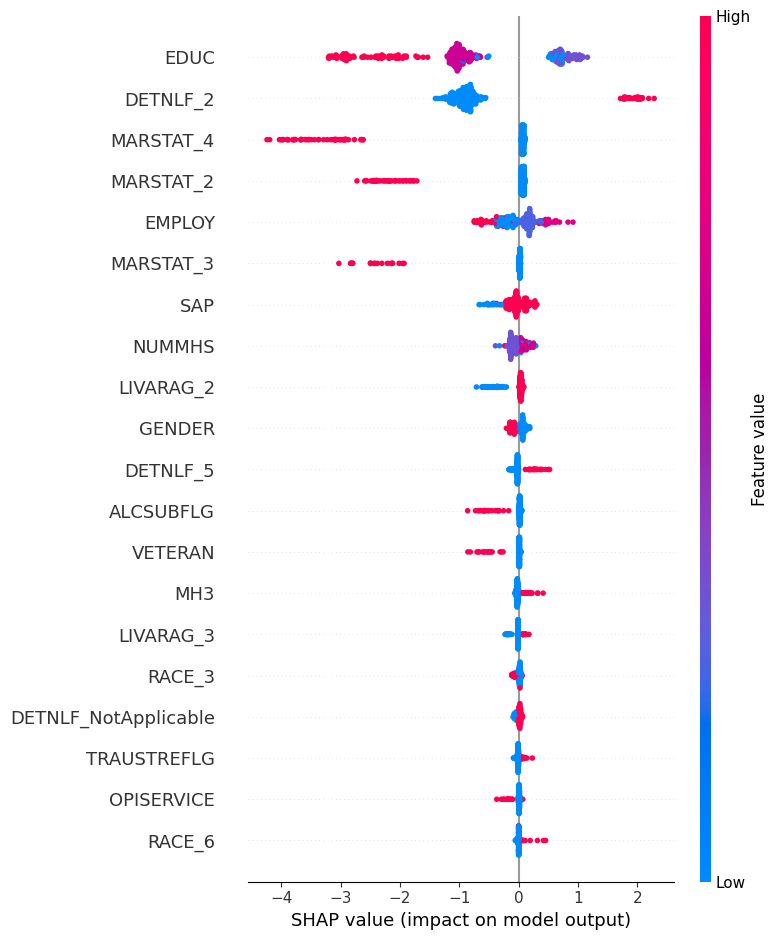


클래스 2 (SED)


/tmp/ipython-input-58-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


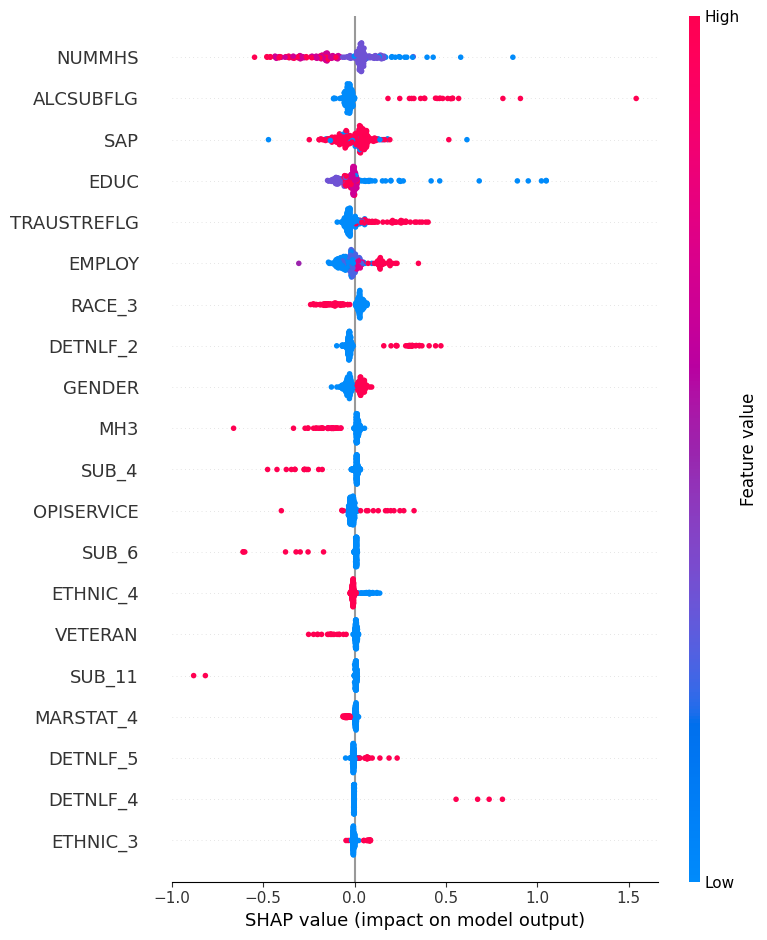

In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.79      0.96      0.87    838304
         SMI       0.55      0.48      0.51     35078
         SED       0.66      0.23      0.34    274399

    accuracy                           0.77   1147781
   macro avg       0.67      0.56      0.58   1147781
weighted avg       0.75      0.77      0.73   1147781



In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


DETNLF_2       0.152777
NUMMHS         0.107779
EMPLOY         0.092555
EDUC           0.089612
TRAUSTREFLG    0.065056
RACE_3         0.060601
SAP            0.055613
MARSTAT_4      0.041339
VETERAN        0.036430
DETNLF_5       0.032752
dtype: float32


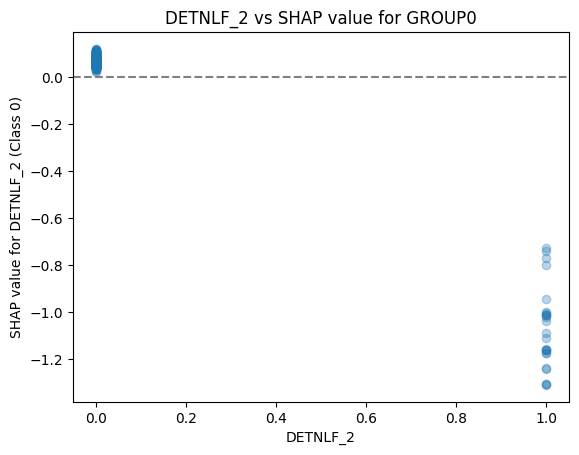

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 0)")
plt.title("DETNLF_2 vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

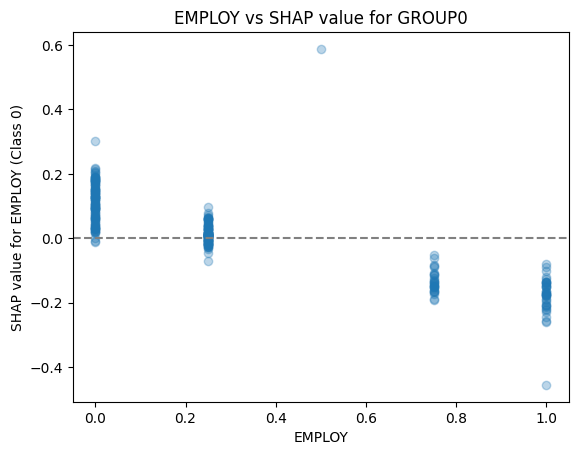

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 0)")
plt.title("EMPLOY vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

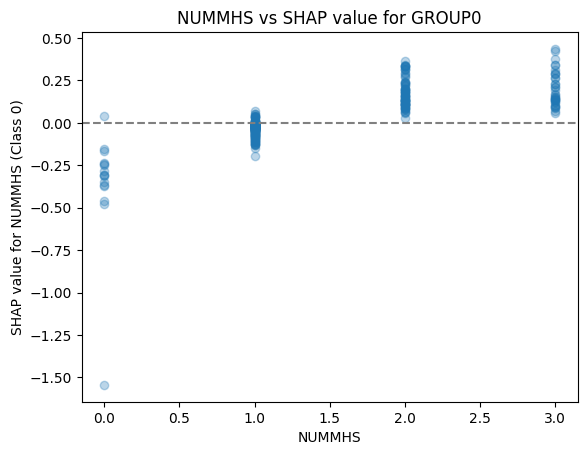

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS (Class 0)")
plt.title("NUMMHS vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

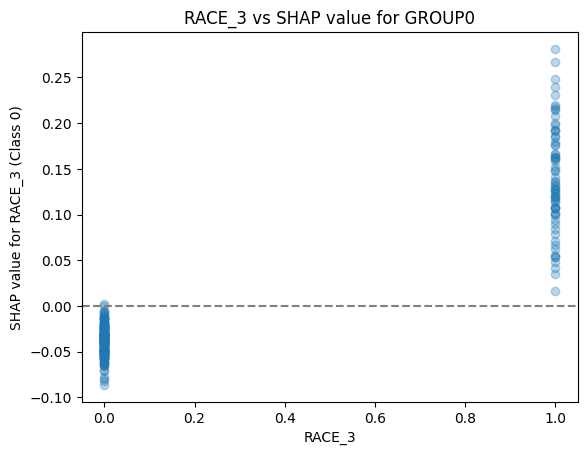

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["RACE_3"], shap_df["RACE_3"], alpha=0.3)
plt.xlabel("RACE_3")
plt.ylabel("SHAP value for RACE_3 (Class 0)")
plt.title("RACE_3 vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

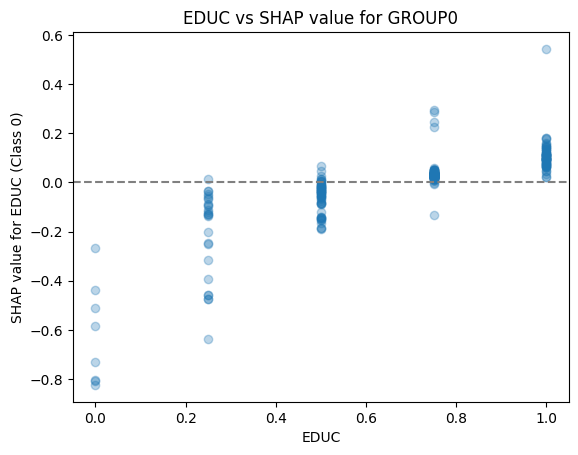

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDUC (Class 0)")
plt.title("EDUC vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


EDUC         1.282978
DETNLF_2     0.999755
MARSTAT_4    0.640310
MARSTAT_2    0.368292
EMPLOY       0.262334
MARSTAT_3    0.178653
SAP          0.128491
NUMMHS       0.106534
LIVARAG_2    0.091574
GENDER       0.079077
dtype: float32


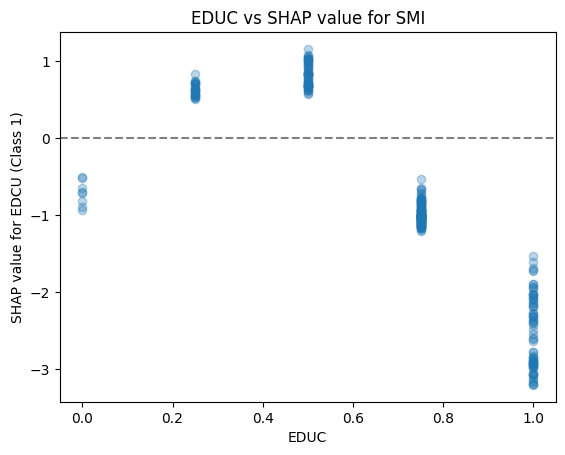

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDCU (Class 1)")
plt.title("EDUC vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


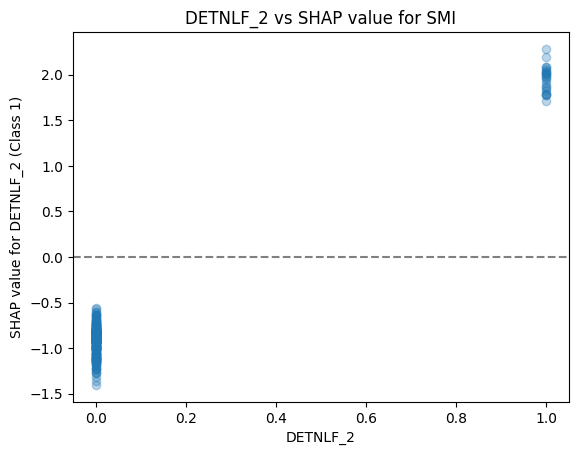

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


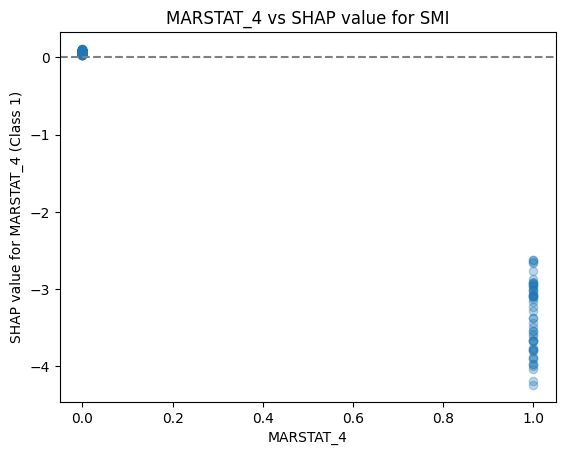

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["MARSTAT_4"], shap_df["MARSTAT_4"], alpha=0.3)
plt.xlabel("MARSTAT_4")
plt.ylabel("SHAP value for MARSTAT_4 (Class 1)")
plt.title("MARSTAT_4 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


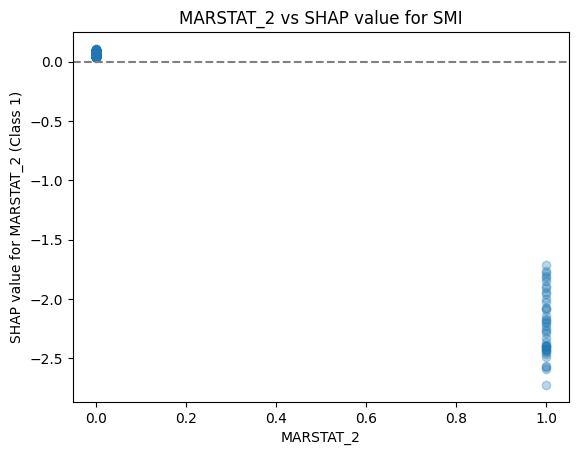

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["MARSTAT_2"], shap_df["MARSTAT_2"], alpha=0.3)
plt.xlabel("MARSTAT_2")
plt.ylabel("SHAP value for MARSTAT_2 (Class 1)")
plt.title("MARSTAT_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


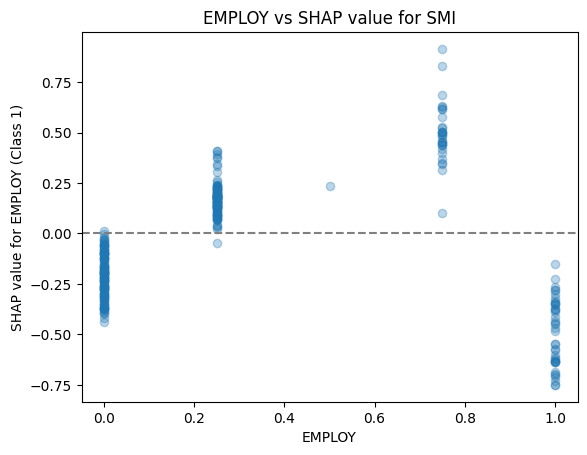

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 1)")
plt.title("EMPLOY vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


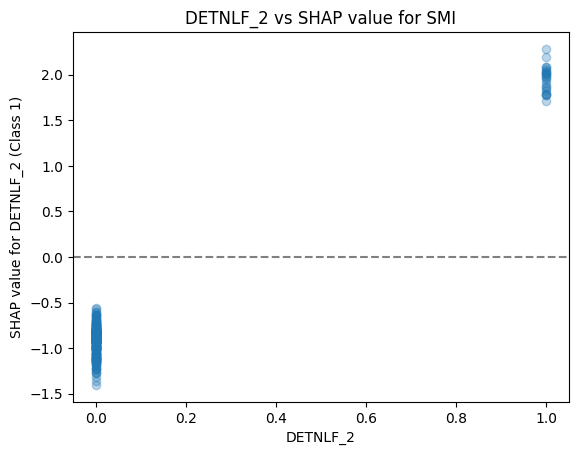

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

NUMMHS         0.131028
ALCSUBFLG      0.065905
SAP            0.063832
EDUC           0.063470
TRAUSTREFLG    0.056419
EMPLOY         0.056214
RACE_3         0.054148
DETNLF_2       0.053841
GENDER         0.036659
MH3            0.034001
dtype: float32


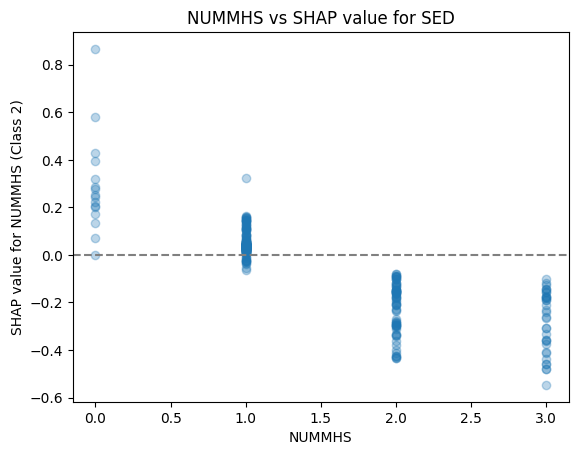

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS (Class 2)")
plt.title("NUMMHS vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


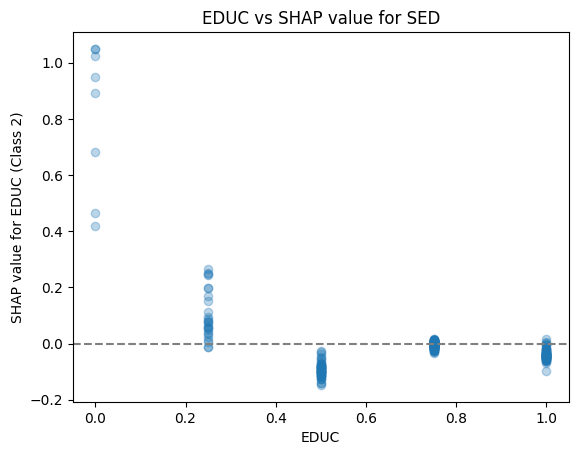

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDUC (Class 2)")
plt.title("EDUC vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


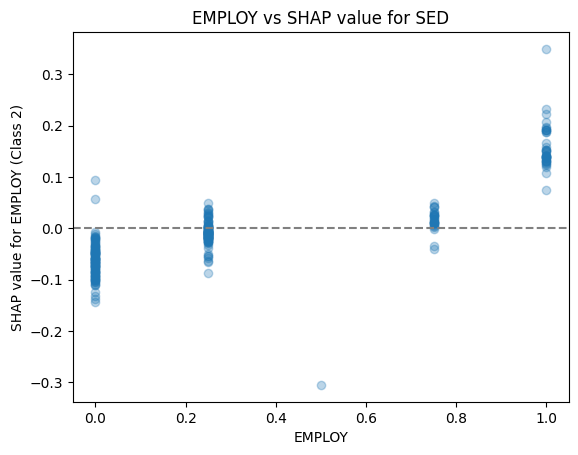

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 2)")
plt.title("EMPLOY vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


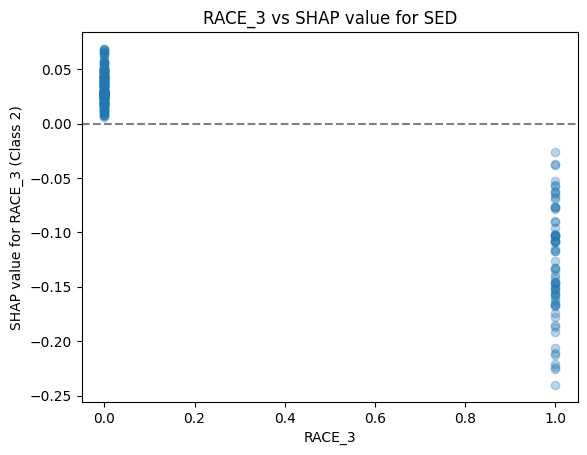

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["RACE_3"], shap_df["RACE_3"], alpha=0.3)
plt.xlabel("RACE_3")
plt.ylabel("SHAP value for RACE_3 (Class 2)")
plt.title("RACE_3 vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


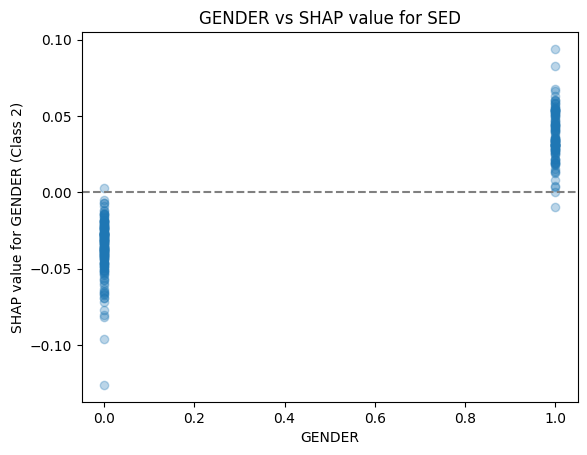

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["GENDER"], shap_df["GENDER"], alpha=0.3)
plt.xlabel("GENDER")
plt.ylabel("SHAP value for GENDER (Class 2)")
plt.title("GENDER vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


# **STEP4. 로지스틱 회귀분석**

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]

diagnosis_vars = [
    'MH1', 'MH2', 'MH3',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG','OTHERDISFLG', 'AGE'
]

region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]


group0_vars = ['DETNLF_2', 'EDUC', 'RACE_3', 'EMPLOY']
group1_vars = ['EDUC', 'DETNLF_2', 'MARSTAT_4', 'MARSTAT_2']
group2_vars = ['NUMMHS', 'EDUC', 'DETNLF_2']

X_base = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"] + diagnosis_vars+ region_vars, errors='ignore')


scaler = StandardScaler()

for grp, vars in zip(['GROUP0', 'GROUP1', 'GROUP2'],
                     [group0_vars, group1_vars, group2_vars]):

    print(f"\n===== {grp} One-vs-Rest Logistic =====")

    X = X_base[vars].copy()

    # 스케일링
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=vars)
    X_scaled = sm.add_constant(X_scaled)

    # 타겟: 현재 그룹 vs 나머지
    y_bin = (y == int(grp[-1])).astype(int)

    model = sm.Logit(y_bin, X_scaled)
    result = model.fit()

    print(result.summary())




===== GROUP0 One-vs-Rest Logistic =====
Optimization terminated successfully.
         Current function value: 0.537669
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 SMISED   No. Observations:              1147781
Model:                          Logit   Df Residuals:                  1147776
Method:                           MLE   Df Model:                            4
Date:                Fri, 20 Jun 2025   Pseudo R-squ.:                 0.07758
Time:                        17:55:10   Log-Likelihood:            -6.1713e+05
converged:                       True   LL-Null:                   -6.6903e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0612      0.002    472.162      0.000       1.057 